In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import sys
from io import StringIO

old_stderr = sys.stderr
sys.stderr = StringIO()

In [2]:
COMMODITY = 'Copper'

DATE_COLUMN = 'Date'
VALUE_COLUMN = 'Value'  
QUANTITY_COLUMN = 'Std. Quantity (KG)'
UNIT_RATE_COLUMN = 'Std. Unit Rate ($/KG)'
ORIGIN_COUNTRY_COLUMN = 'Country of Origin'
DEST_COUNTRY_COLUMN = 'Country of Destination'

PETROL_FILE_PATH = '../../../volza/petroleum/petrol_crude_oil_spot_price.csv'
VOLZA_FILE_PATH = '../../../volza/copper/copper.csv'

MARKET_SHARE_FILE_PATH = '../'

TIME_METRIC = '7D'


### Preparing Oil Data

In [3]:
petrol_df = pd.read_csv(PETROL_FILE_PATH, delimiter=';', on_bad_lines='warn')
petrol_df['Date'] = pd.to_datetime(petrol_df['Date'])

# Split based on types of oil
brent_df = petrol_df[petrol_df['product-name']=='UK Brent Crude Oil']
wti_df = petrol_df[petrol_df['product-name']=='WTI Crude Oil']

brent_df.rename(columns={'Value':'Brent Oil Value'}, inplace=True)
wti_df.rename(columns={'Value':'WTI Oil Value'}, inplace=True)


### Cleaning up Volza dataset

In [4]:
# Only keep rows where we have usable quantity units (kg, ton) and standardizing it.
def convert_to_kg(df, quantity_col='Std. Quantity', unit_col='Std. Unit'):
    converstion_factors = {
        'TON': 907.185,
        'TNE': 1000,
        'KGS': 1,
        'Kgs': 1,
    }

    df_filtered = df[df[unit_col].isin(converstion_factors.keys())]

    def convert(row):
        unit = row[unit_col]
        quantity = row[quantity_col]
        return quantity * converstion_factors.get(unit,1)
    
    df_filtered = df_filtered[df_filtered[VALUE_COLUMN] != 0]
    df_filtered[QUANTITY_COLUMN] = df_filtered.apply(convert, axis=1)
    df_filtered = df_filtered[df_filtered[QUANTITY_COLUMN] != 0]

    df_filtered[UNIT_RATE_COLUMN] = df_filtered[VALUE_COLUMN] / df_filtered[QUANTITY_COLUMN]

    return df_filtered

### Preparing Export / Import Data

In [5]:
# Function to find top 5 exporters of commodity based on sum of 'Value'
def find_top_exporters(df, n=5):
    top_exporters = df.groupby(ORIGIN_COUNTRY_COLUMN)[VALUE_COLUMN].sum().sort_values(ascending=False).head(n).index.tolist()
    return top_exporters

In [6]:
# Function to find top 10 importers of commodity from an exporter based on sum of 'Value'
def find_top_importers_for_exporters(df, exporters, n=10):
    top_importers_by_exporter = {}
    for exporter in exporters:
        top_importers = df[df[ORIGIN_COUNTRY_COLUMN] == exporter].groupby(DEST_COUNTRY_COLUMN)[VALUE_COLUMN].sum().sort_values(ascending=False).head(n).index.tolist()
        top_importers_by_exporter[exporter] = top_importers
    return top_importers_by_exporter


### Setting up & Cleaning up the main dataframe

In [7]:

combined_df = pd.read_csv(VOLZA_FILE_PATH)
combined_df = convert_to_kg(combined_df)
combined_df[DATE_COLUMN] = pd.to_datetime(combined_df[DATE_COLUMN], format='mixed')
combined_df = combined_df.merge(brent_df[[DATE_COLUMN, 'Brent Oil Value']], on=DATE_COLUMN, how='left')
combined_df = combined_df.merge(wti_df[[DATE_COLUMN, 'WTI Oil Value']], on=DATE_COLUMN, how='left')
combined_df.sort_values(DATE_COLUMN, inplace=True)
combined_df.set_index(DATE_COLUMN, inplace=True)
combined_df.head(5)

0   HS Code  \
Date                          
2019-01-01  26641  74020000   
2019-01-01  23547  74020000   
2019-01-01  23548  74020000   
2019-01-01    187  74020000   
2019-01-01  23549  74020000   

                                          Product Description Consignee  \
Date                                                                      
2019-01-01  COPPER, UNREFINED; COPPER ANODES FOR ELECTROLY...       NaN   
2019-01-01  COPPER, UNREFINED; COPPER ANODES FOR ELECTROLY...       NaN   
2019-01-01  COPPER, UNREFINED; COPPER ANODES FOR ELECTROLY...       NaN   
2019-01-01  COPPER, UNREFINED; COPPER ANODES FOR ELECTROLY...       NaN   
2019-01-01  COPPER, UNREFINED; COPPER ANODES FOR ELECTROLY...       NaN   

           Notify Party Name Shipper  Std. Quantity Std. Unit  \
Date                                                            
2019-01-01               NaN     NaN        753.540       TON   
2019-01-01               NaN     NaN          0.070       TON   
2019-01-01               NaN     NaN          0.003       TON   
2019-01-01               NaN     NaN          0.065       TON   
2019-01-01               NaN     NaN          0.051       TON   

           Standard Unit Rate INR       Value  ... HS Product Description  \
Date                                           ...                          
2019-01-01                      -  4429242.53  ...                    NaN   
2019-01-01                      -    12588.51  ...                    NaN   
2019-01-01                      -      464.37  ...                    NaN   
2019-01-01                      -     4521.84  ...                    NaN   
2019-01-01                      -     1678.16  ...                    NaN   

           Gross Weight Consignee Address  Shipper Address  \
Date                                                         
2019-01-01          0.0               NaN              NaN   
2019-01-01          0.0               NaN              NaN   
2019-01-01          0.0               NaN              NaN   
2019-01-01          0.0               NaN              NaN   
2019-01-01          0.0               NaN              NaN   

           Notify Party Address               Country Name Std. Quantity (KG)  \
Date                                                                            
2019-01-01                  NaN         Belgium T1  Export      683600.184900   
2019-01-01                  NaN  United Kingdom T1  Export          63.502950   
2019-01-01                  NaN           Italy T1  Export           2.721555   
2019-01-01                  NaN  United Kingdom T1  Export          58.967025   
2019-01-01                  NaN         Germany T1  Export          46.266435   

           Std. Unit Rate ($/KG) Brent Oil Value WTI Oil Value  
Date                                                            
2019-01-01              6.479288             NaN           NaN  
2019-01-01            198.235043             NaN           NaN  
2019-01-01            170.626719             NaN           NaN  
2019-01-01             76.684215             NaN           NaN  
2019-01-01             36.271651             NaN           NaN  

[5 rows x 35 columns]

### Splitting data into **Top Exporters** & **Top Importers from said Top Exporters**

In [8]:
top_exporters = find_top_exporters(combined_df, n=5)
top_importers_by_exporter = find_top_importers_for_exporters(combined_df, top_exporters, n=10)
print(top_exporters)
print(top_importers_by_exporter)

['Zambia', 'Pakistan', 'Chile', 'Bulgaria', 'Slovakia']
{'Zambia': ['India', 'Tanzania', 'Belgium', 'Netherlands', 'Germany', 'Brazil', 'Poland'], 'Pakistan': ['China', 'Hong Kong', 'Belgium'], 'Chile': ['China', 'Canada', 'South Korea', 'Germany', 'Spain', 'Belgium', 'Japan', 'Brazil', 'Netherlands', 'United States'], 'Bulgaria': ['Belgium', 'Germany', 'Italy', 'Portugal', 'Netherlands', 'Malaysia', 'Latvia', 'Egypt'], 'Slovakia': ['Austria', 'Sweden', 'Italy', 'Romania', 'Czech Republic', 'Belgium', 'Netherlands', 'Hungary']}


### **Analysis**

#### **1. Time Series**
##### **1.1 Crude Oils**

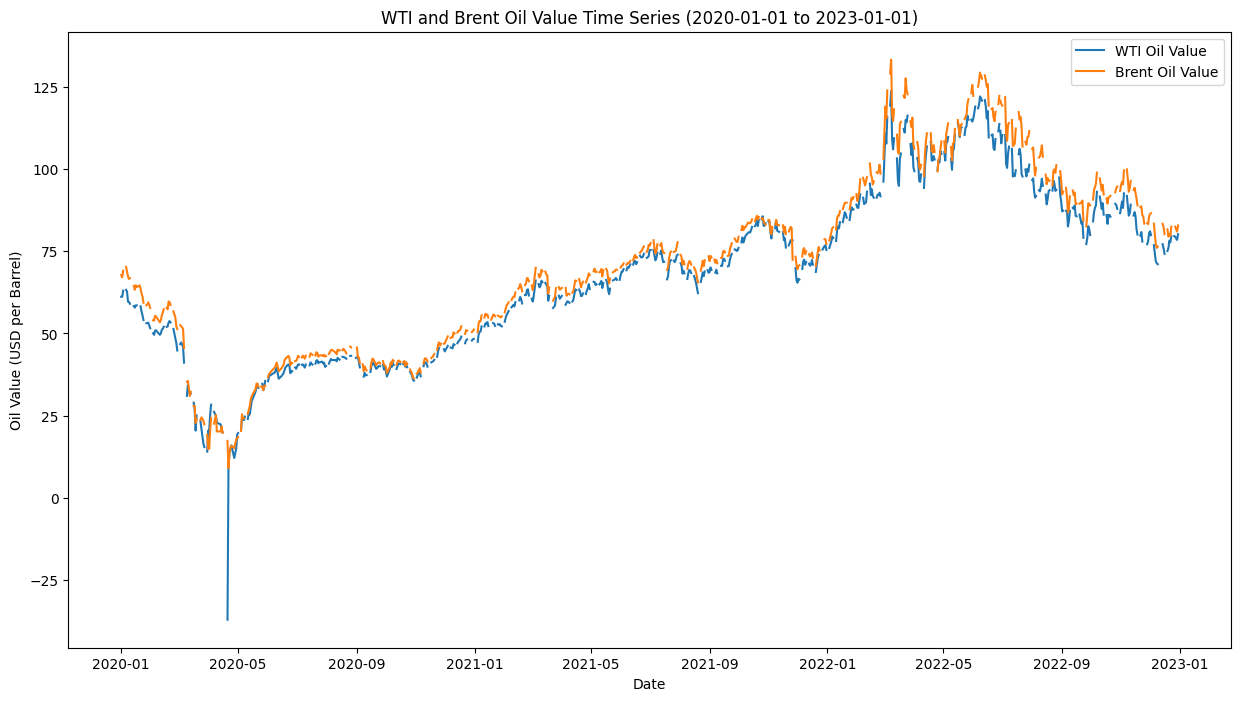

In [9]:
# Setting start & end date to match that of Volza's
start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2023-01-01')

filtered_df = combined_df[(combined_df.index >= start_date) & (combined_df.index <= end_date)]

# Plotting the time series for 'WTI Oil Value' and 'Brent Oil Value'
plt.figure(figsize=(15, 8))
plt.plot(filtered_df.index, filtered_df['WTI Oil Value'], label='WTI Oil Value')
plt.plot(filtered_df.index, filtered_df['Brent Oil Value'], label='Brent Oil Value')
plt.title('WTI and Brent Oil Value Time Series (2020-01-01 to 2023-01-01)')
plt.xlabel('Date')
plt.ylabel('Oil Value (USD per Barrel)')
plt.legend()
plt.show()


#### **1.2 Global Commodity Shipment Trend**

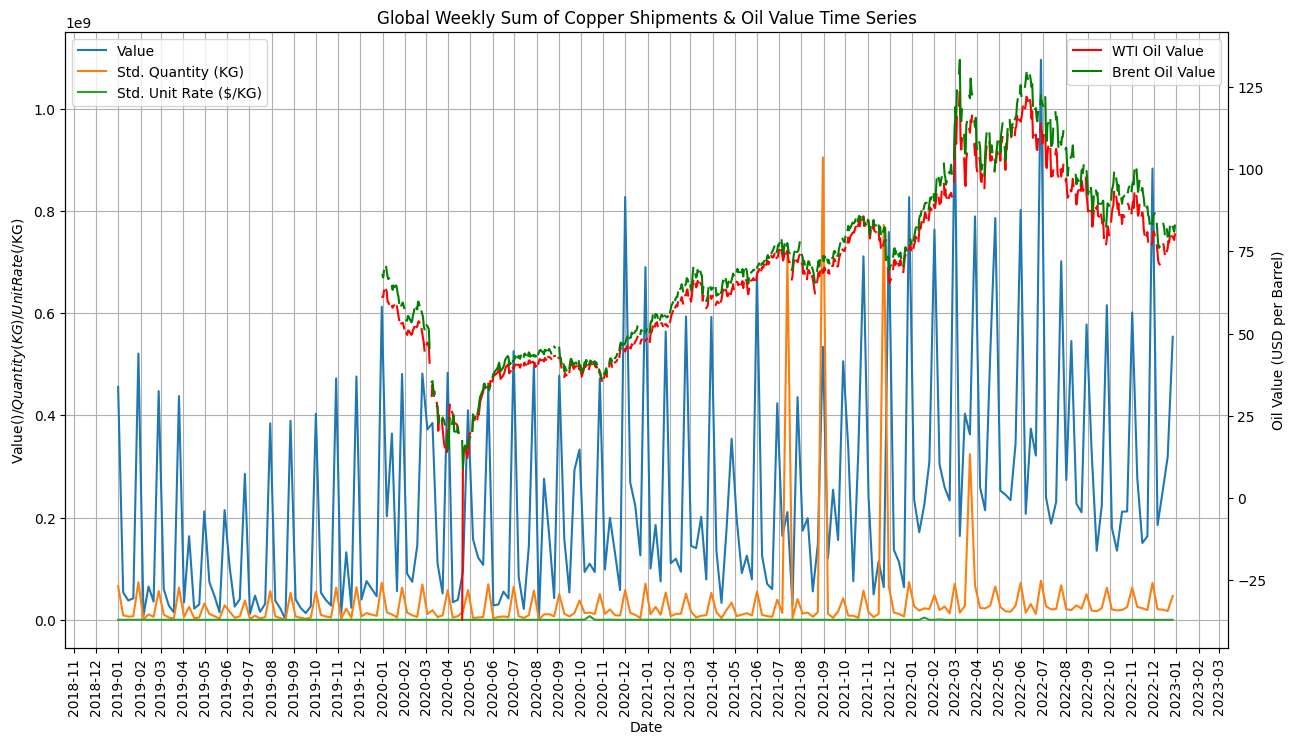

In [10]:

NUMERIC_COLUMN = [VALUE_COLUMN, QUANTITY_COLUMN, UNIT_RATE_COLUMN]

# Resample and sum the data globally
weekly_global_data = combined_df[NUMERIC_COLUMN].resample(TIME_METRIC).sum()

fig, ax1 = plt.subplots(figsize=(15, 8))

for column in NUMERIC_COLUMN:
    ax1.plot(weekly_global_data.index, weekly_global_data[column], label=column)

ax1.set_title(f'Global Weekly Sum of {COMMODITY} Shipments & Oil Value Time Series')
ax1.set_xlabel('Date')
ax1.set_ylabel('Value($) / Quantity(KG) / Unit Rate ($/KG)')
ax1.legend(loc='upper left')
ax1.grid(True)
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Filtering the oil data
start_date = '2020-01-01'
end_date = '2023-01-01'
filtered_df = combined_df[(combined_df.index >= pd.to_datetime(start_date)) & (combined_df.index <= pd.to_datetime(end_date))]

# Create a second y-axis for the oil data
ax2 = ax1.twinx()
ax2.plot(filtered_df.index, filtered_df['WTI Oil Value'], label='WTI Oil Value', color='red')
ax2.plot(filtered_df.index, filtered_df['Brent Oil Value'], label='Brent Oil Value', color='green')
ax2.set_ylabel('Oil Value (USD per Barrel)')
ax2.legend(loc='upper right')

ax1.tick_params(axis='x', rotation=90)
plt.show()


##### **1.3 [Top 5 Exporters] to [Global]**

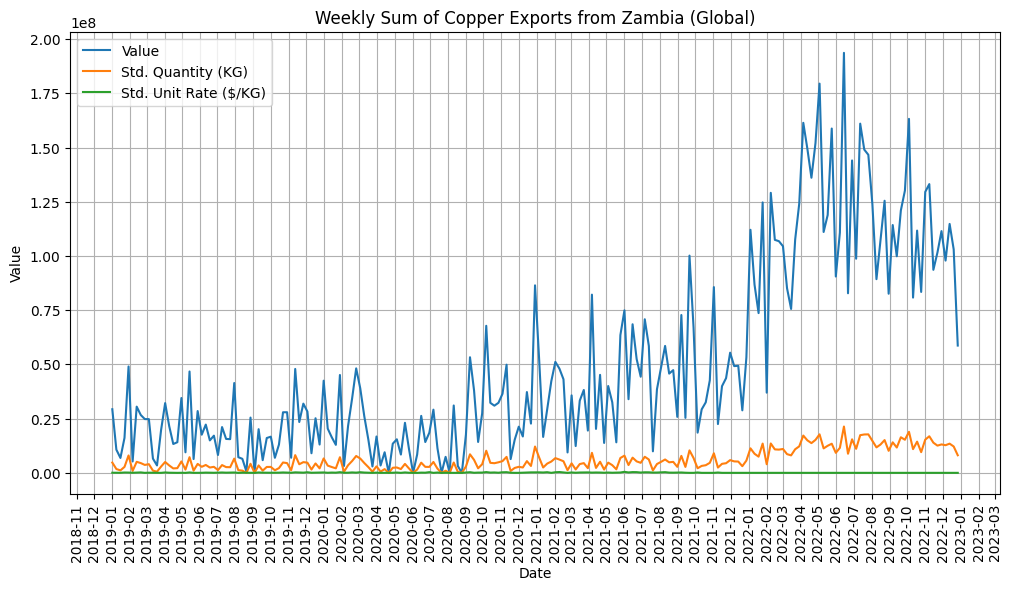

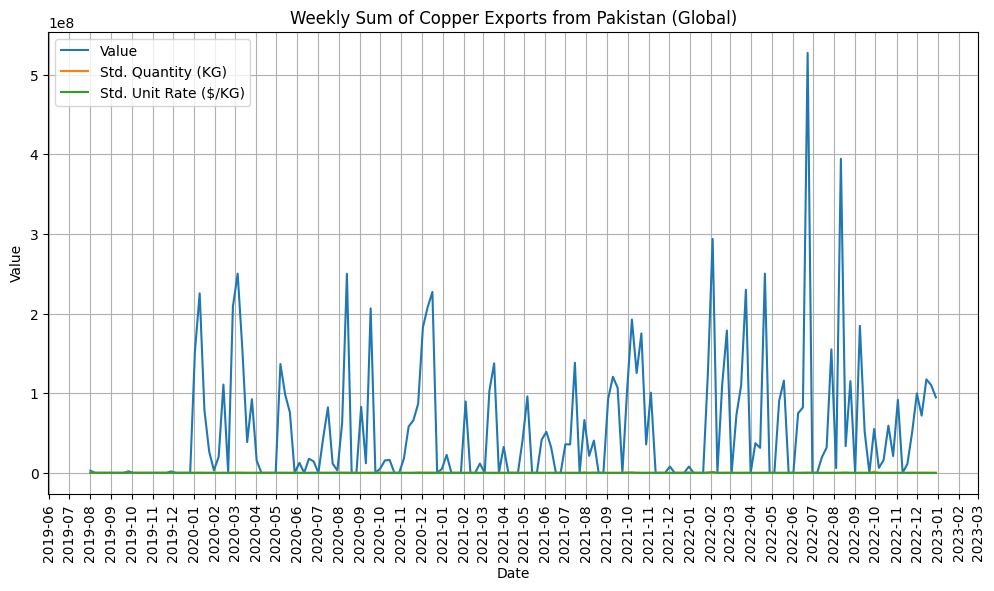

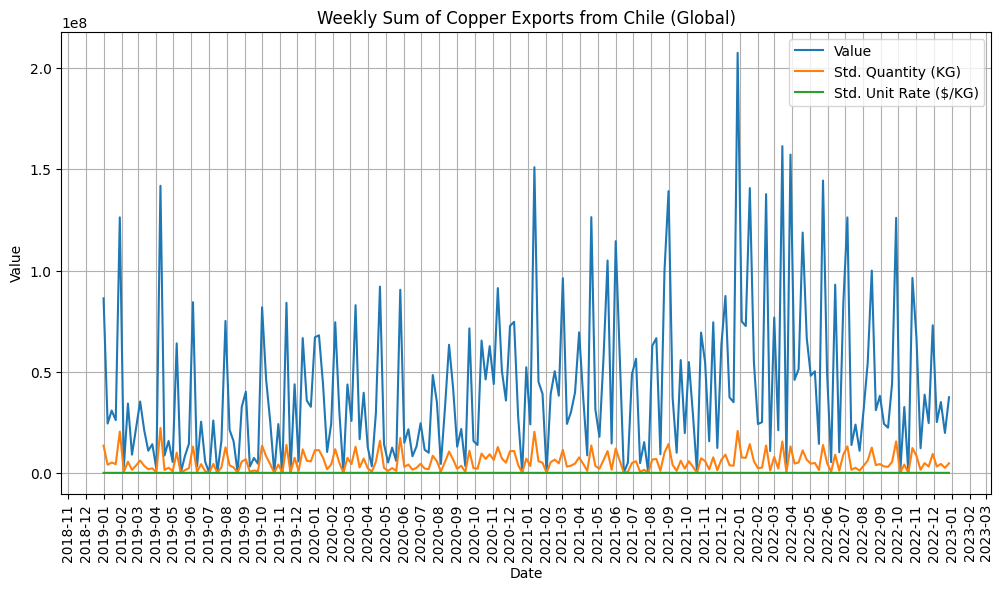

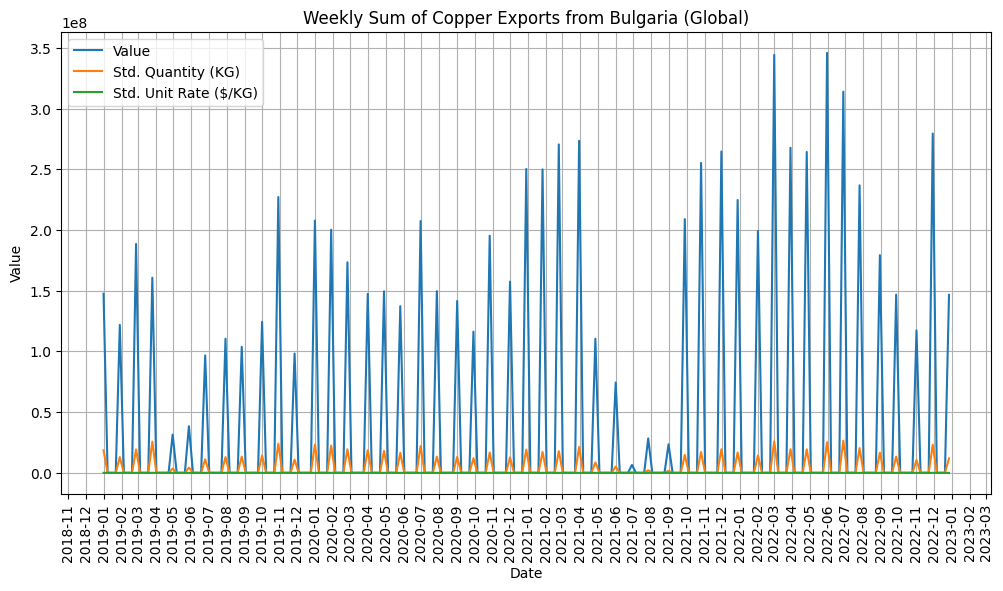

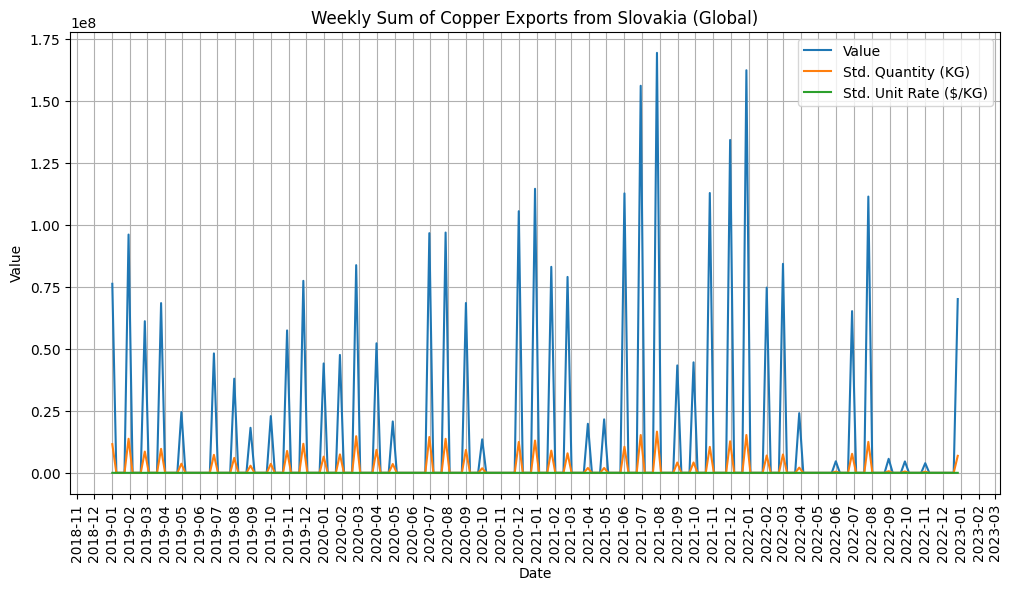

In [11]:
for exporter in top_exporters:
    export_import_data = combined_df[(combined_df[ORIGIN_COUNTRY_COLUMN] == exporter)]

    # Resample and sum
    weekly_data = export_import_data[NUMERIC_COLUMN].resample(TIME_METRIC).sum()

    # Plotting
    plt.figure(figsize=(12, 6))
    for column in NUMERIC_COLUMN:
        plt.plot(weekly_data.index, weekly_data[column], label=column)

    plt.title(f'Weekly Sum of {COMMODITY} Exports from {exporter} (Global)')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=90)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.show()

##### **1.4 Market Control by the Top 5 Exporters**

In [29]:
# Function to find top 5 exporters for a specific year
def find_top_exporters_per_year(df, year, n=5):
    df_year = df[df['Date'].dt.year == year]
    return df_year.groupby(ORIGIN_COUNTRY_COLUMN)[VALUE_COLUMN].sum().sort_values(ascending=False).head(n).index.tolist()

In [45]:
# Function to calculate market shares
def calculate_market_shares(df, year, top_exporters):
    df_year = df[df['Date'].dt.year == year]
    total_value_year = df_year[QUANTITY_COLUMN].sum()
    market_shares = []
    for exporter in top_exporters:
        exporter_total_value = df_year[df_year[ORIGIN_COUNTRY_COLUMN] == exporter][QUANTITY_COLUMN].sum()
        market_share = (exporter_total_value / total_value_year) * 100
        market_shares.append({'Exporter': exporter, 'Total Value ($)': exporter_total_value, 'Market Share (%)': market_share})

    market_share_df = pd.DataFrame(market_shares)
    market_share_df.sort_values(by='Market Share (%)', ascending=False, inplace=True)
    return market_share_df

In [31]:
# Function to plot market shares
def plot_market_shares(df, year):
    df.plot(kind='bar', x='Exporter', y='Market Share (%)', title=f"Top 5 Exporters Market Share in {year}")
    plt.ylabel('Market Share (%)')
    plt.show()

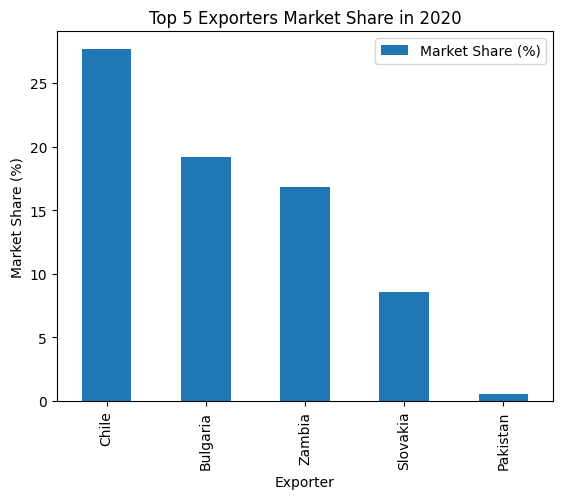

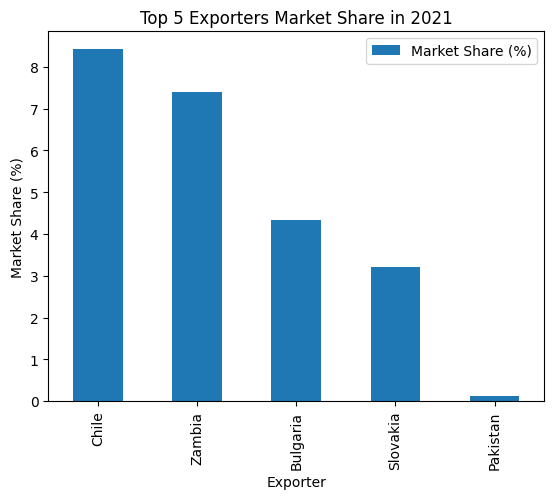

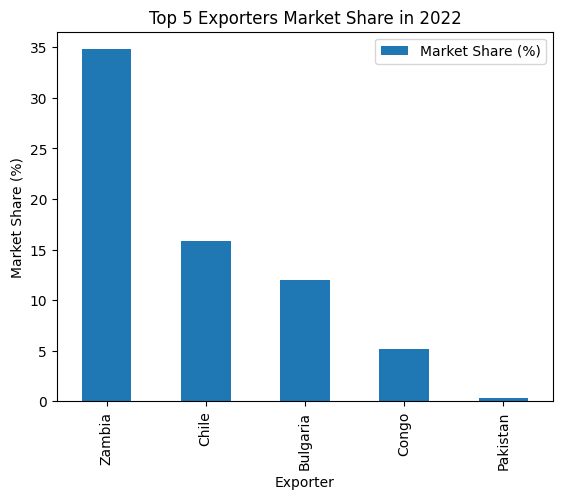

In [46]:
# Main execution
combined_df_reset = combined_df.reset_index()
with pd.ExcelWriter('copper_market_share (quantity).xlsx', engine='xlsxwriter') as writer:
    for year in range(2020, 2023):
        top_exporters_year = find_top_exporters_per_year(combined_df_reset, year)
        market_share_df_year = calculate_market_shares(combined_df_reset, year, top_exporters_year)
        market_share_df_year.to_excel(writer, sheet_name=str(year), index=False)
        plot_market_shares(market_share_df_year, year)

##### **1.5 [Top 5 Exporters] to their [Top 10 Importers]**

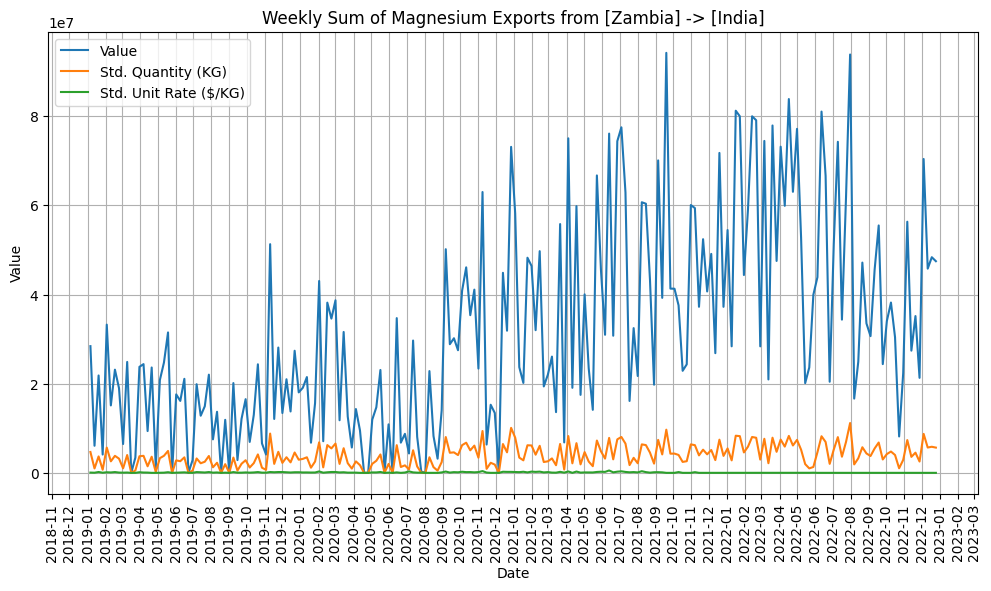

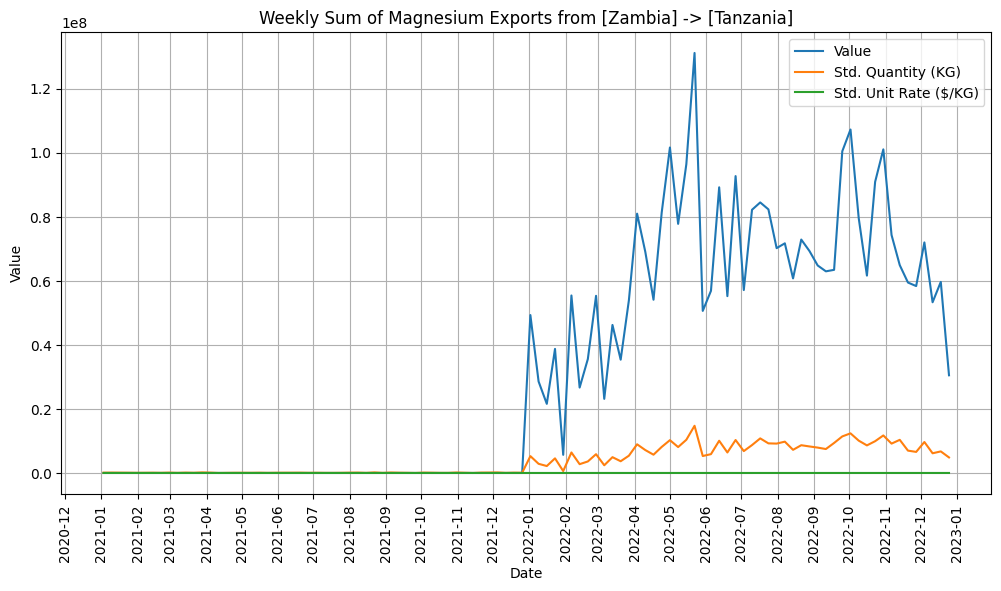

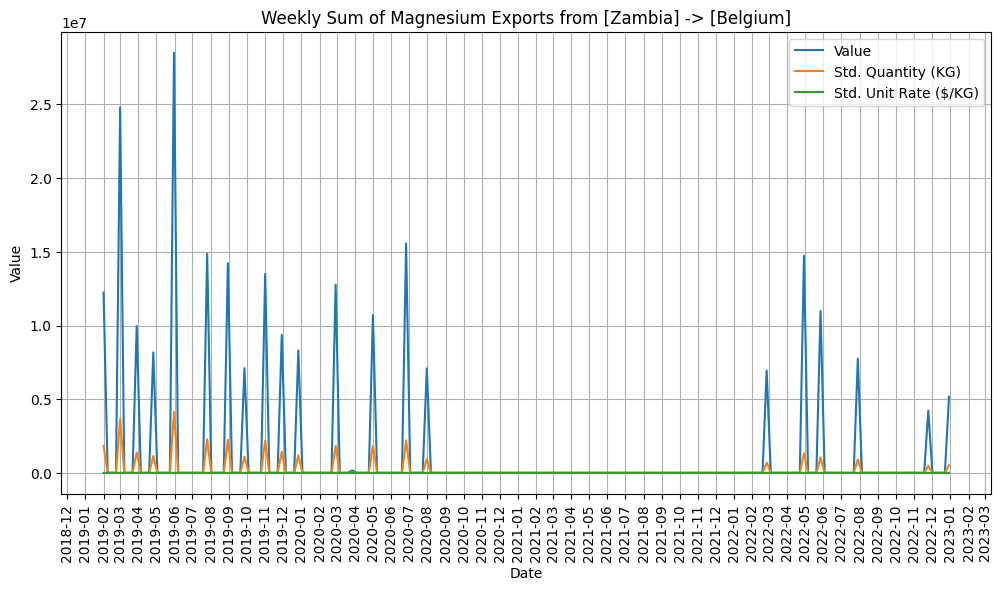

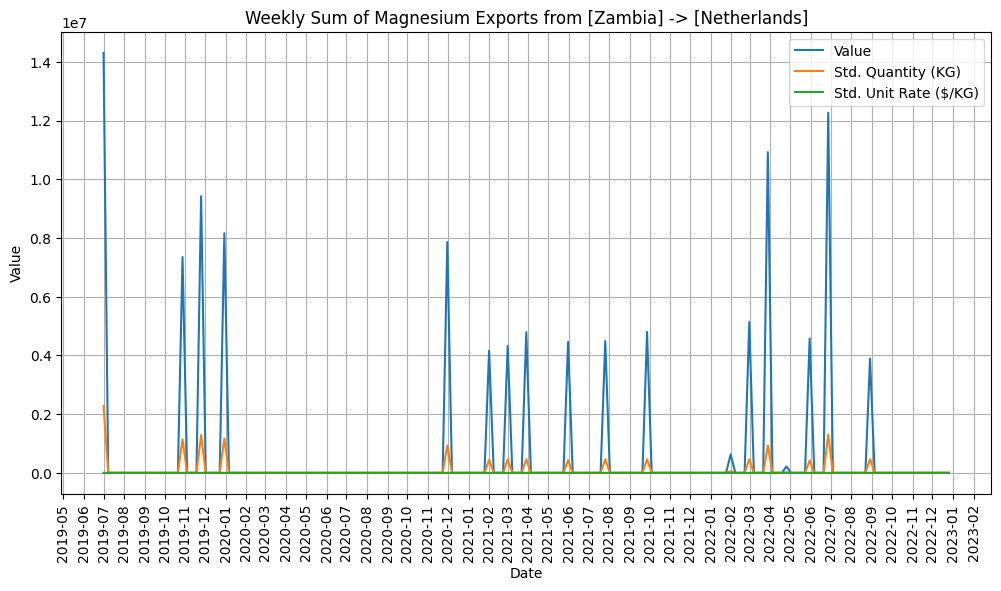

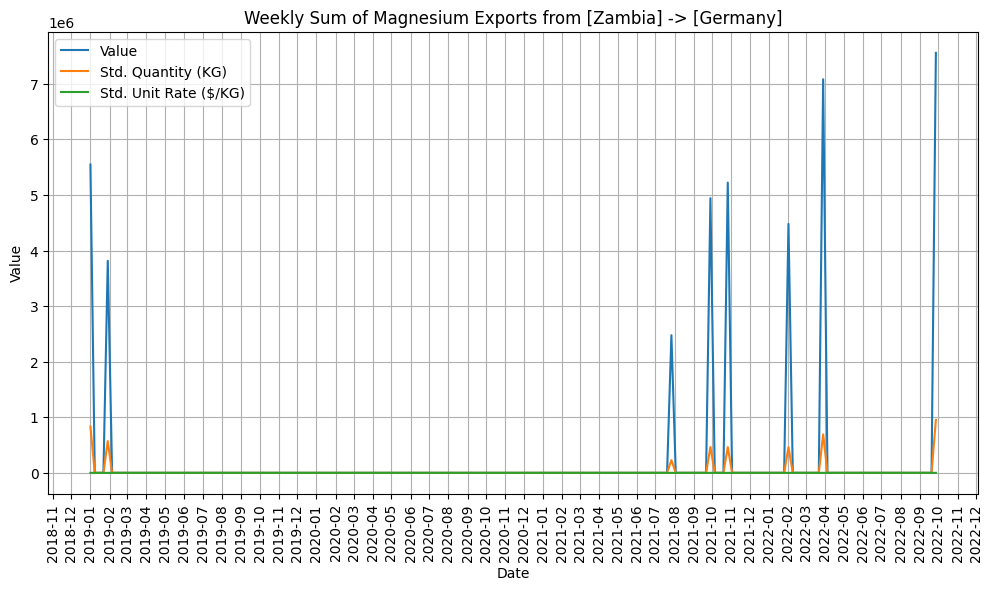

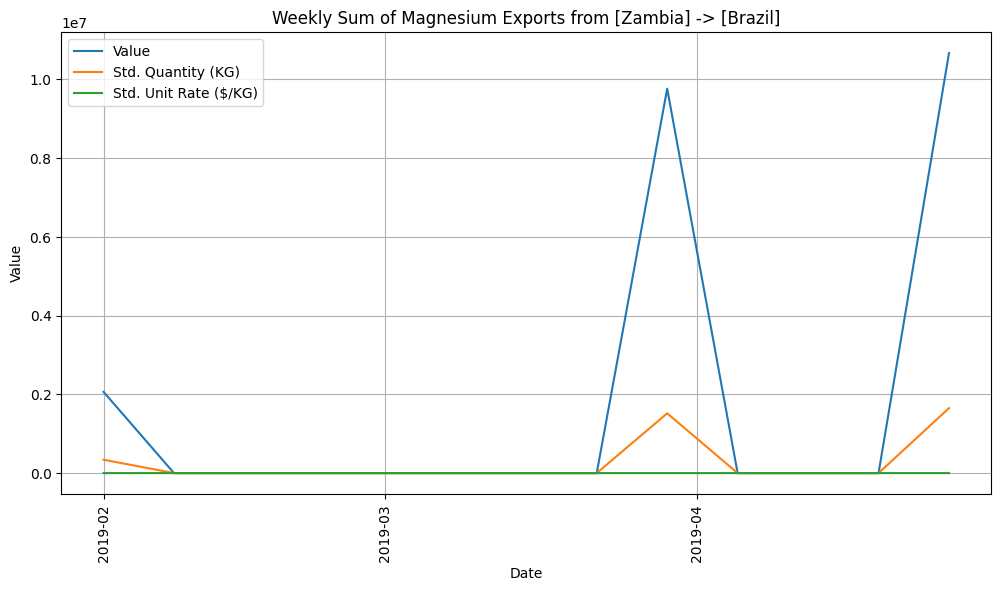

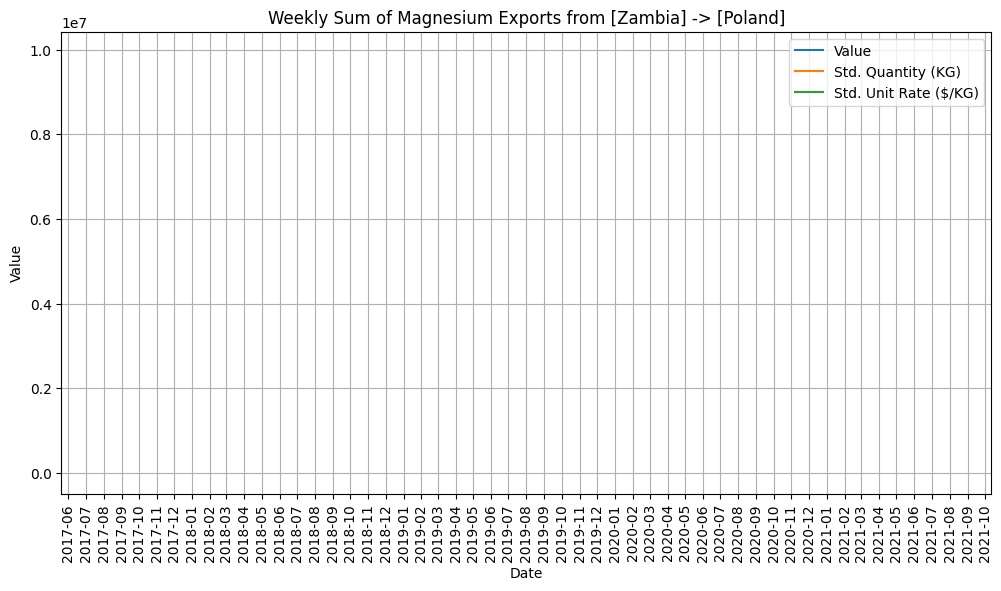

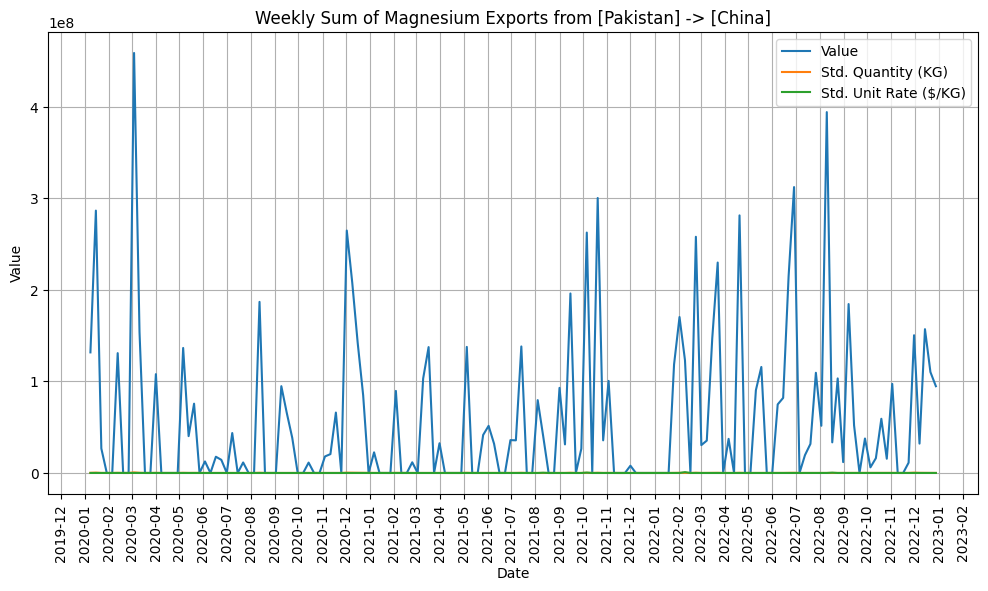

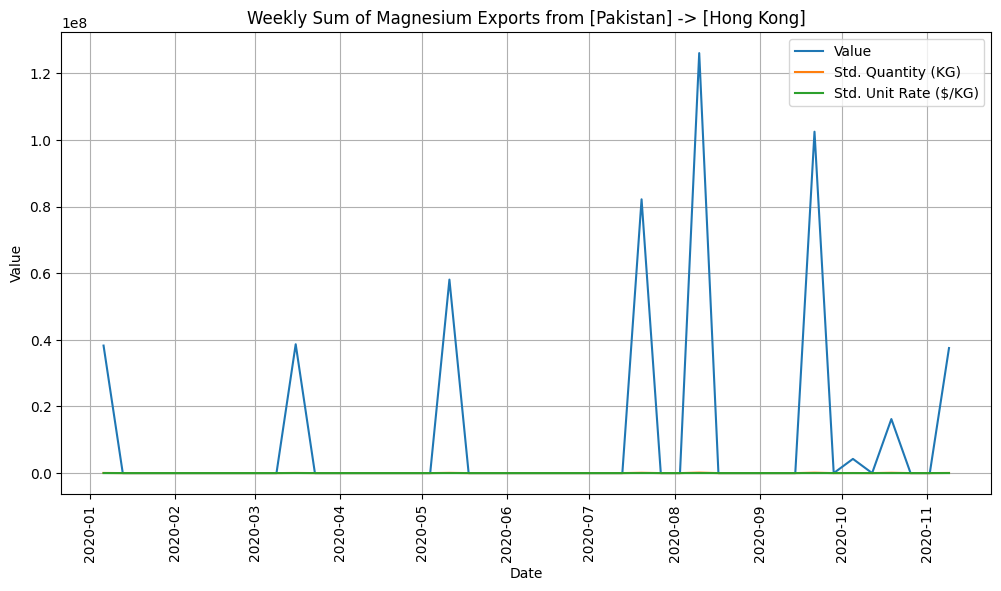

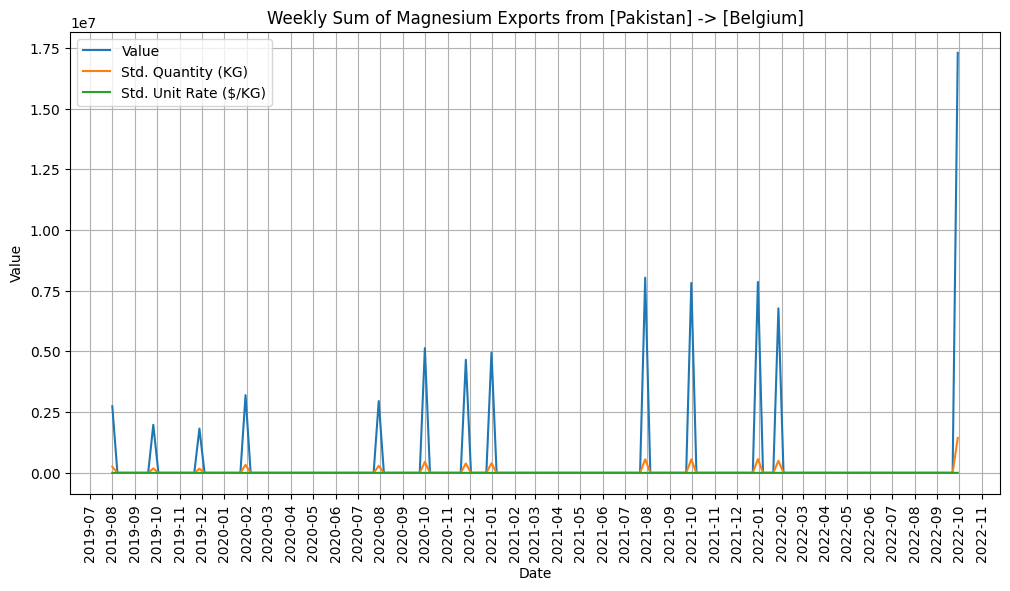

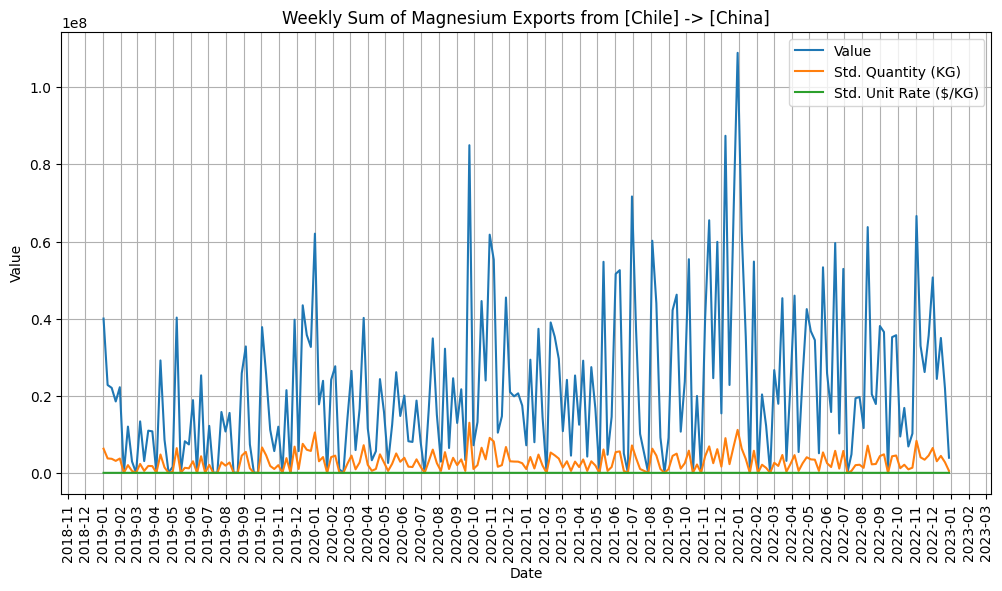

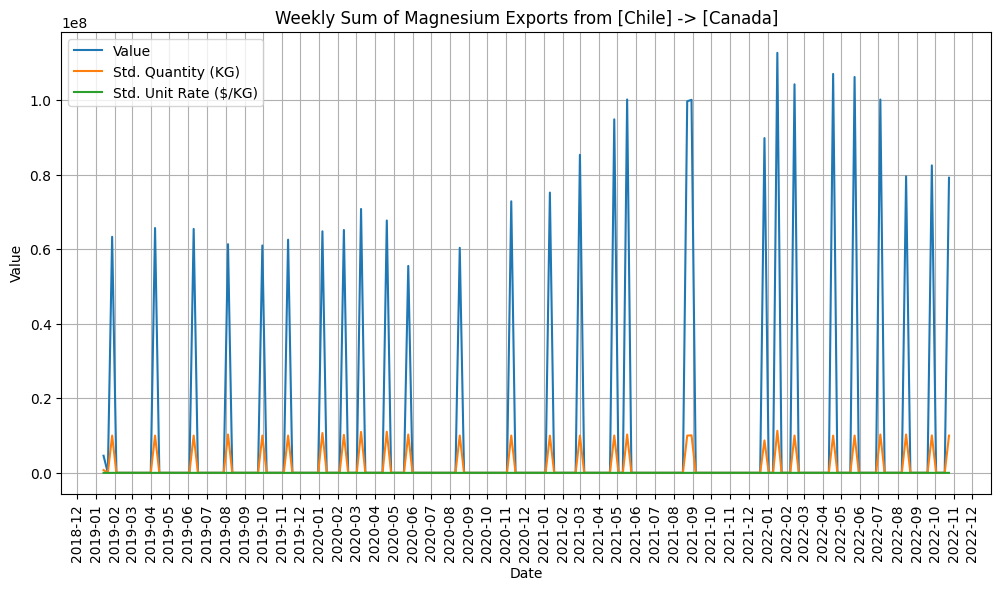

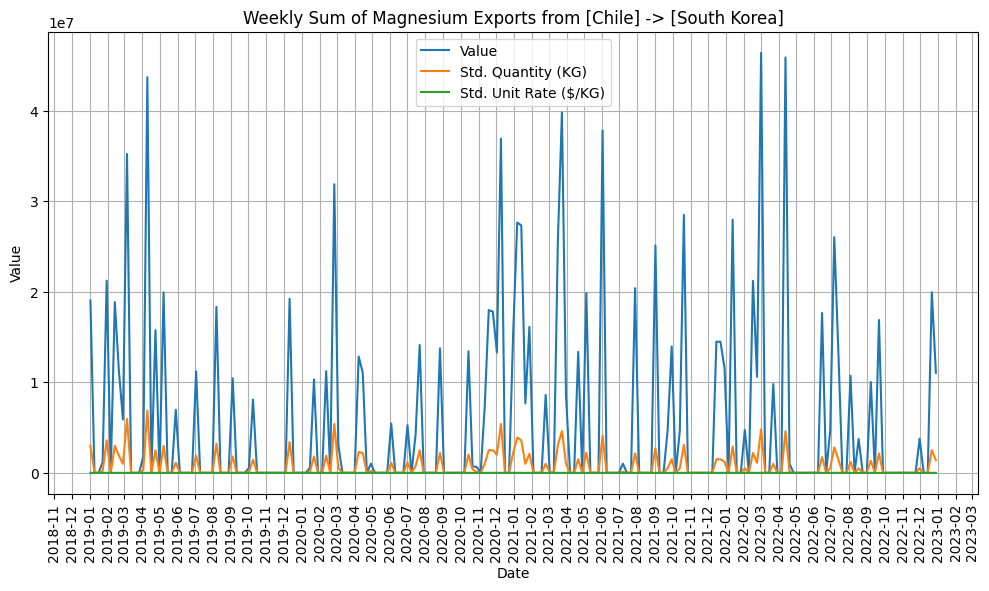

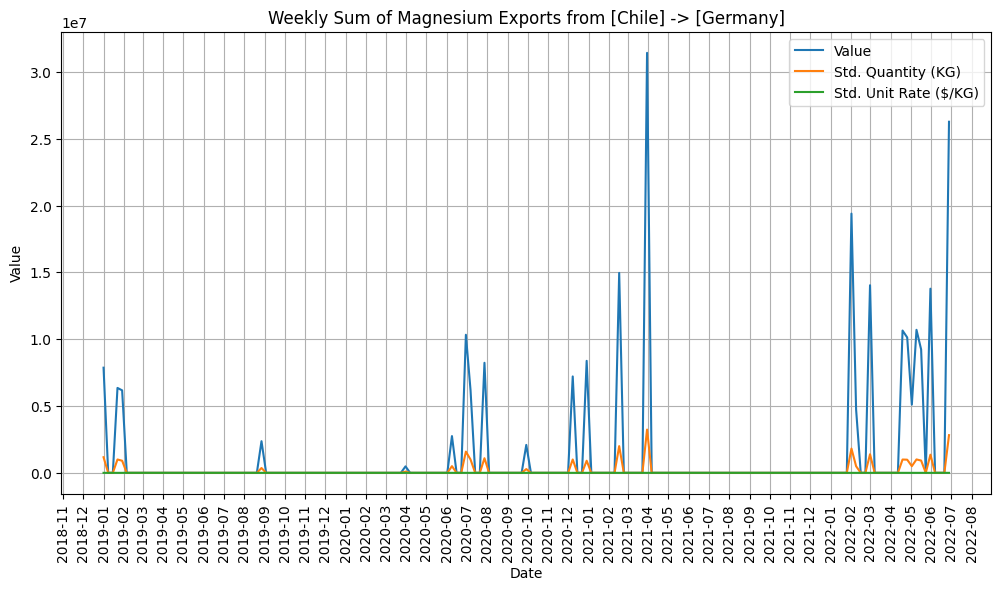

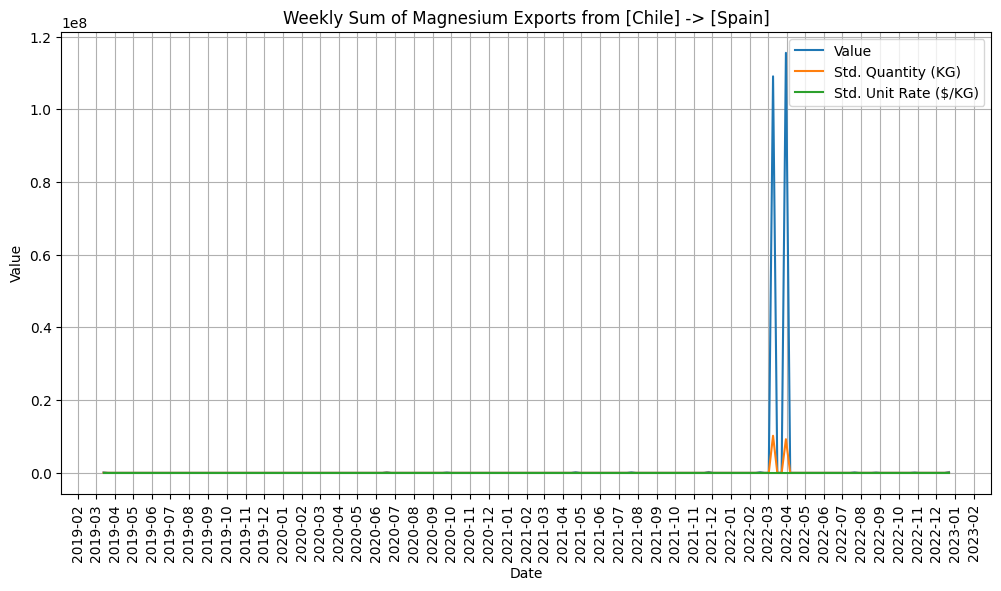

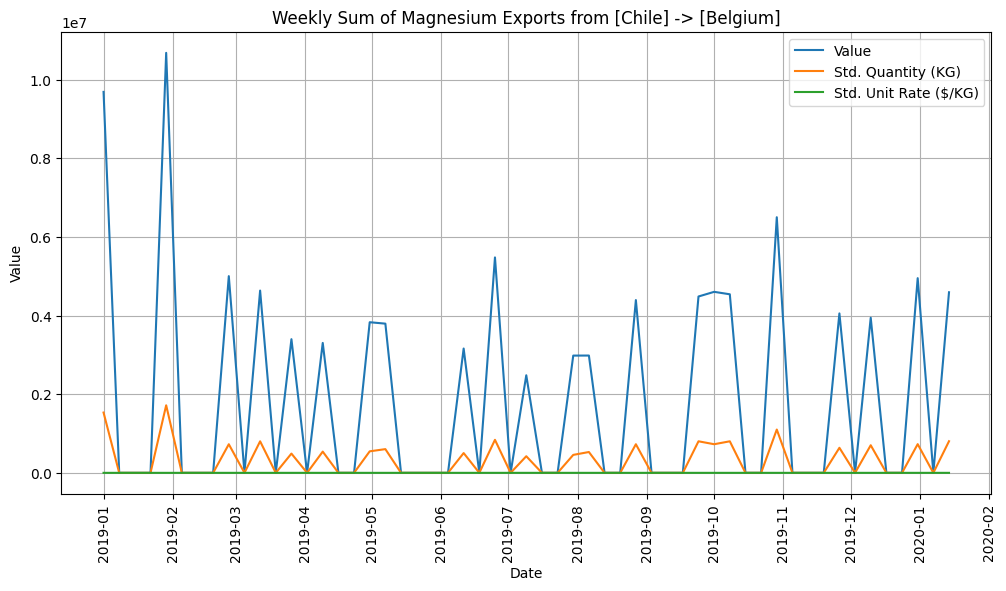

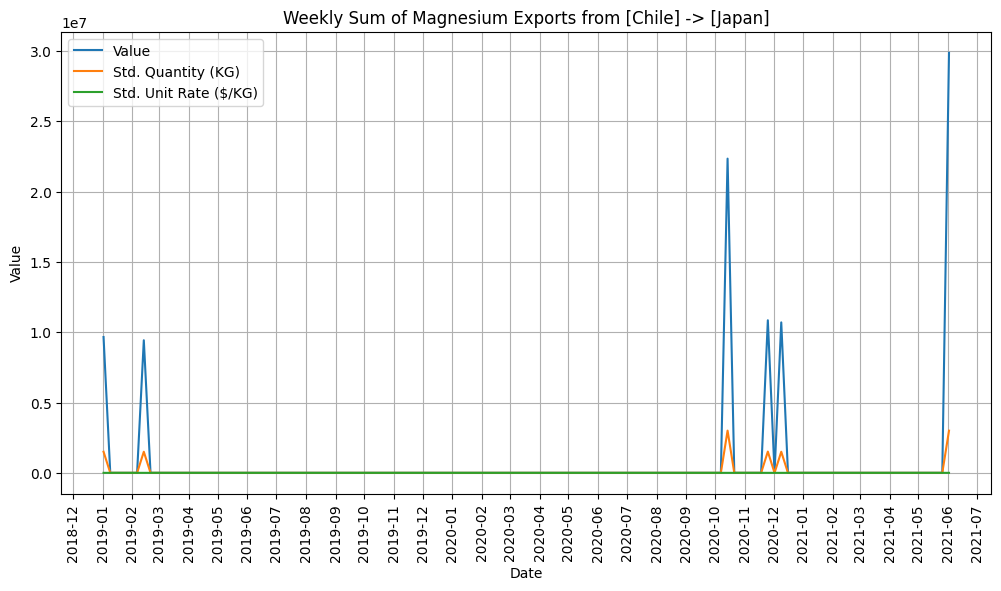

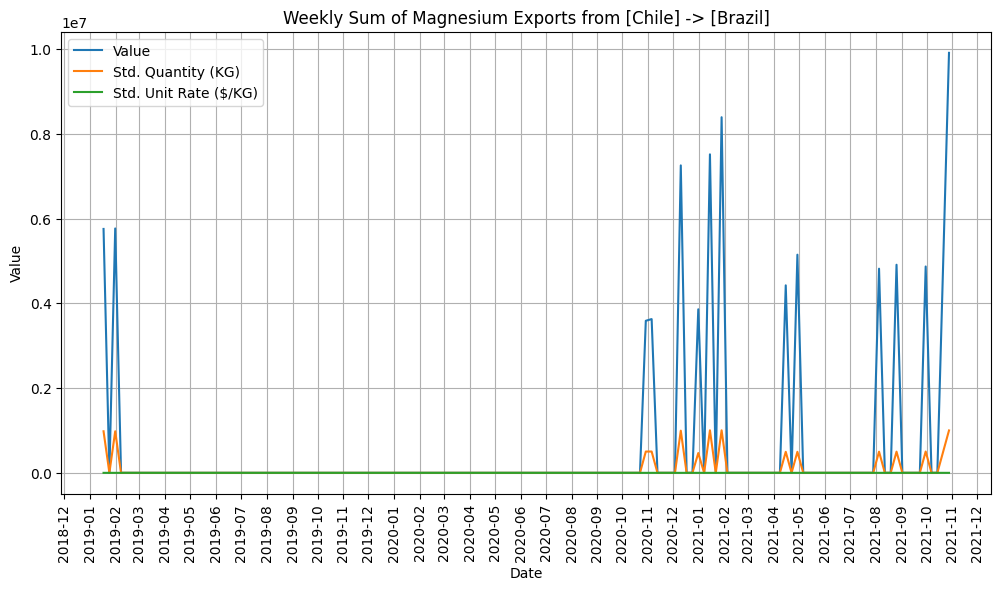

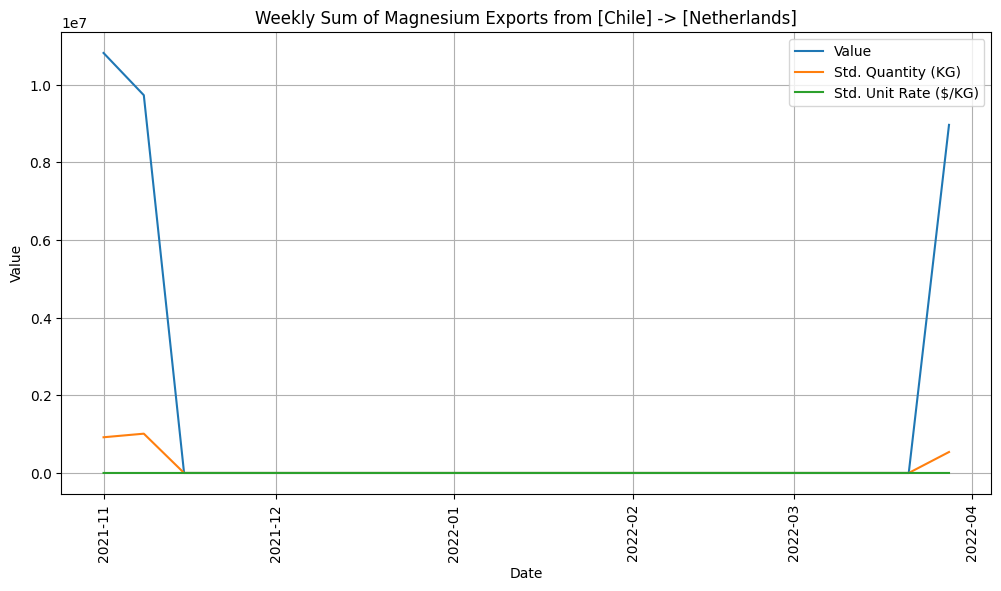

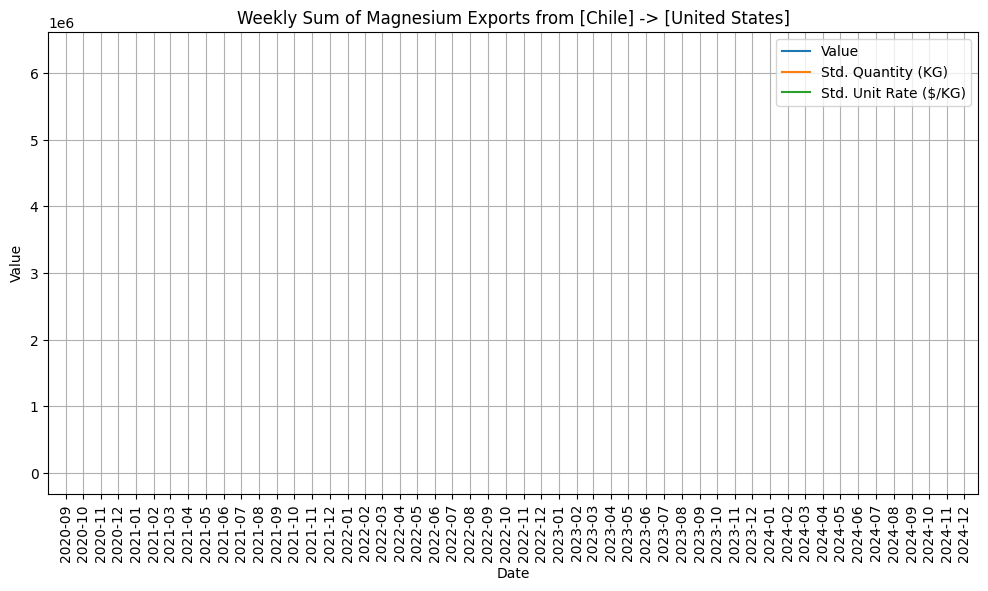

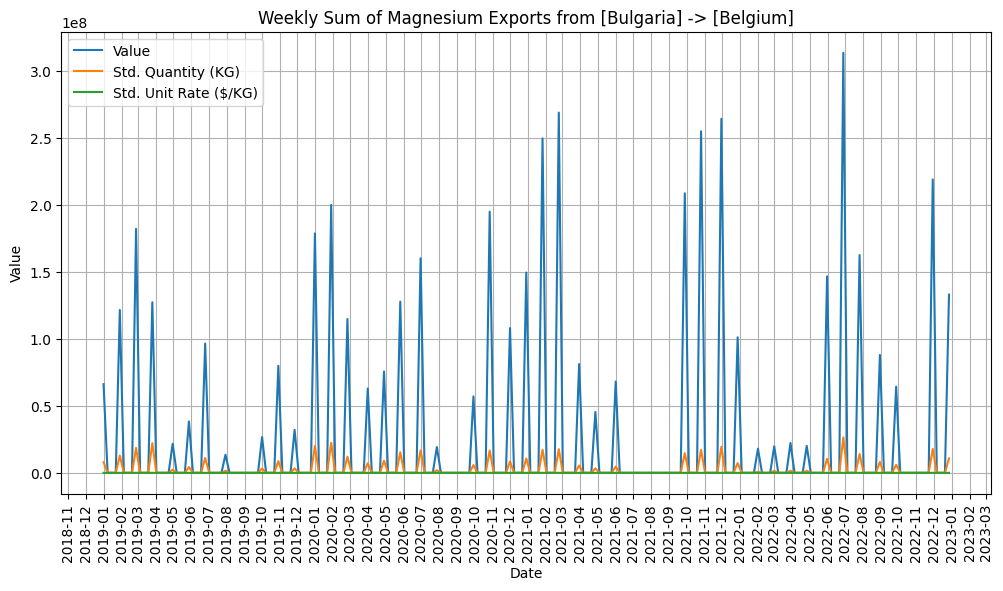

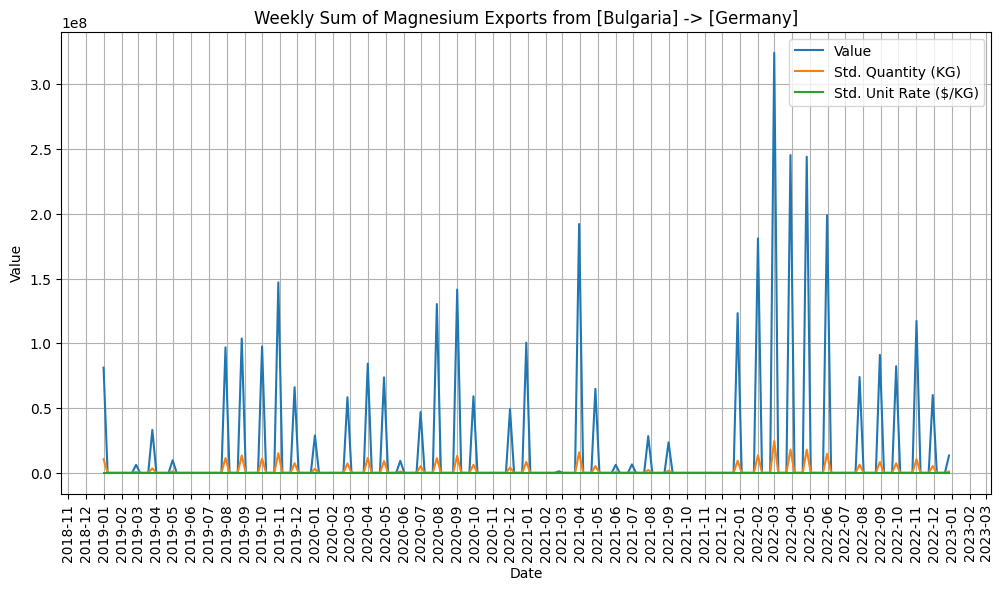

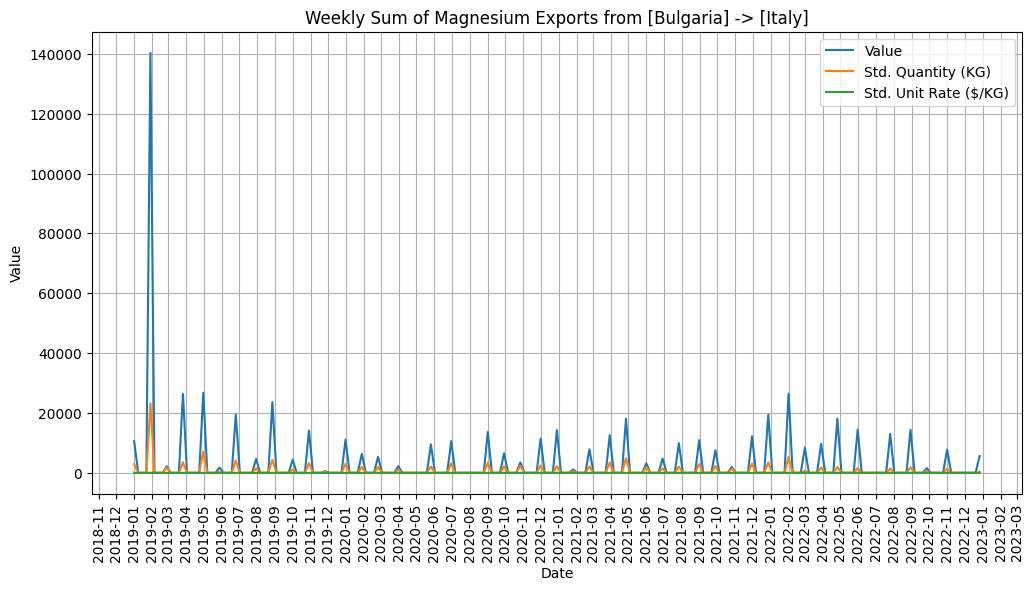

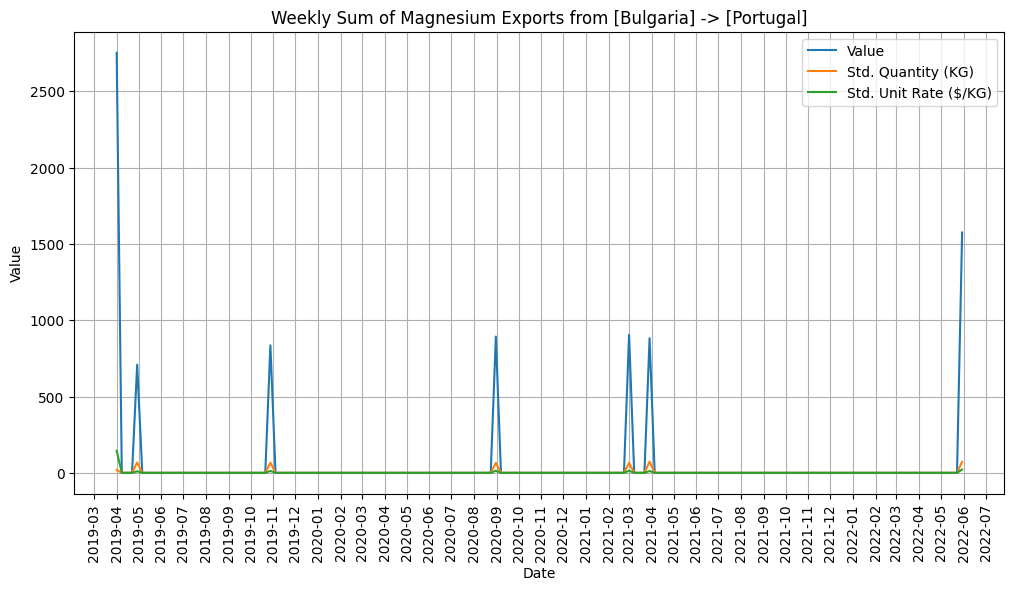

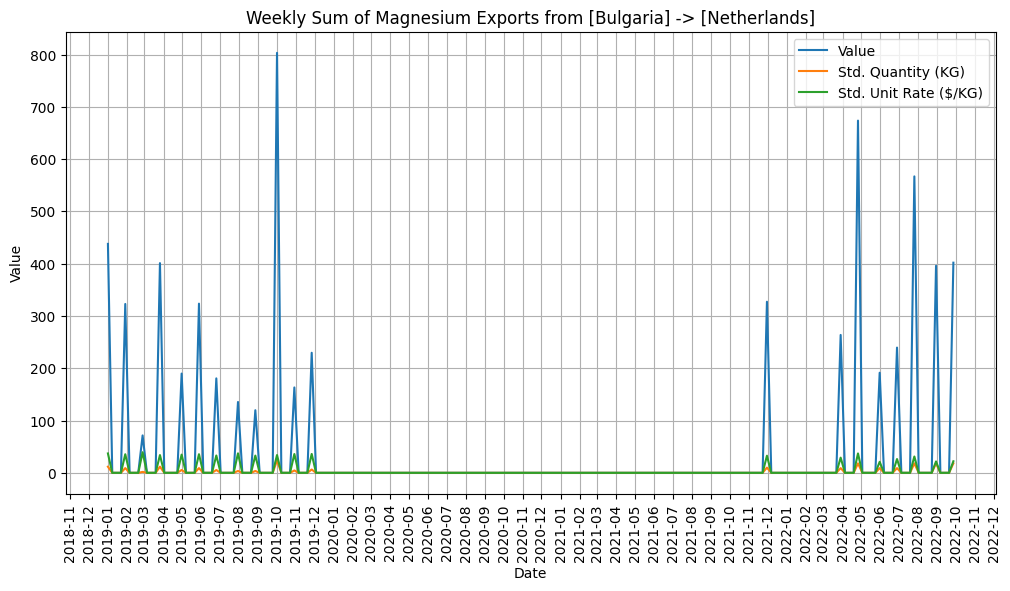

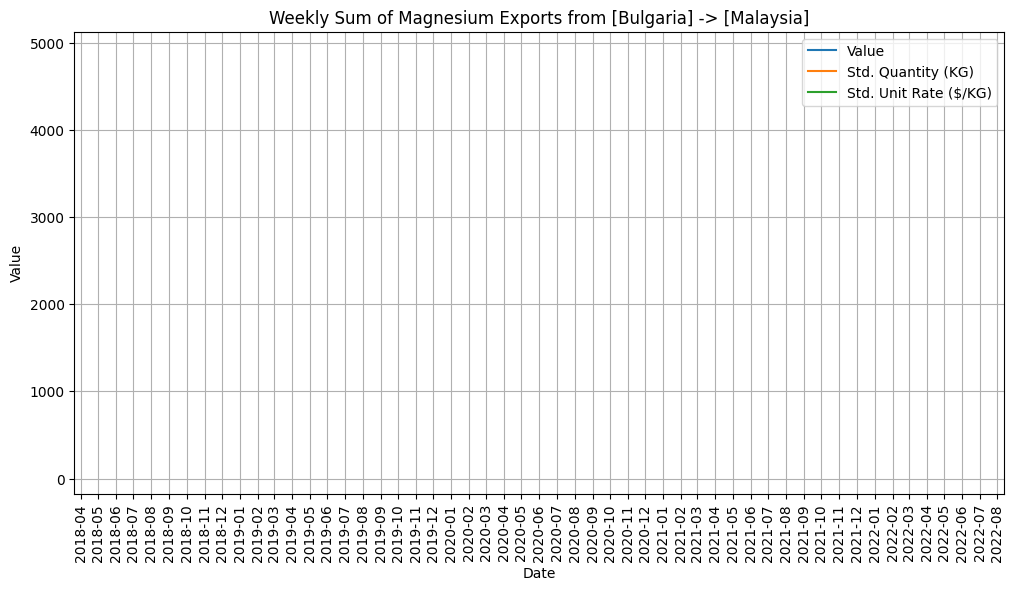

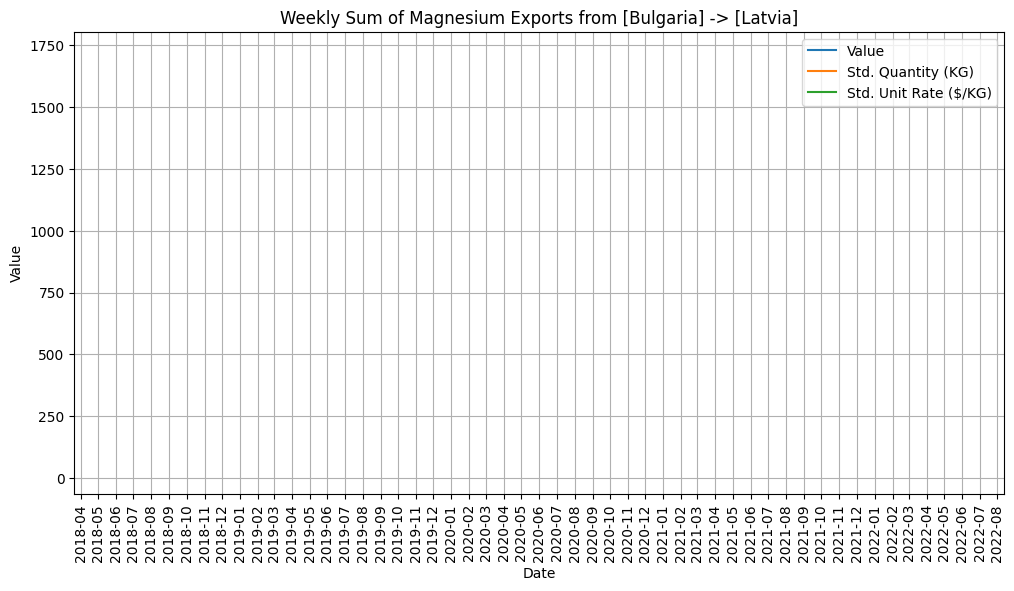

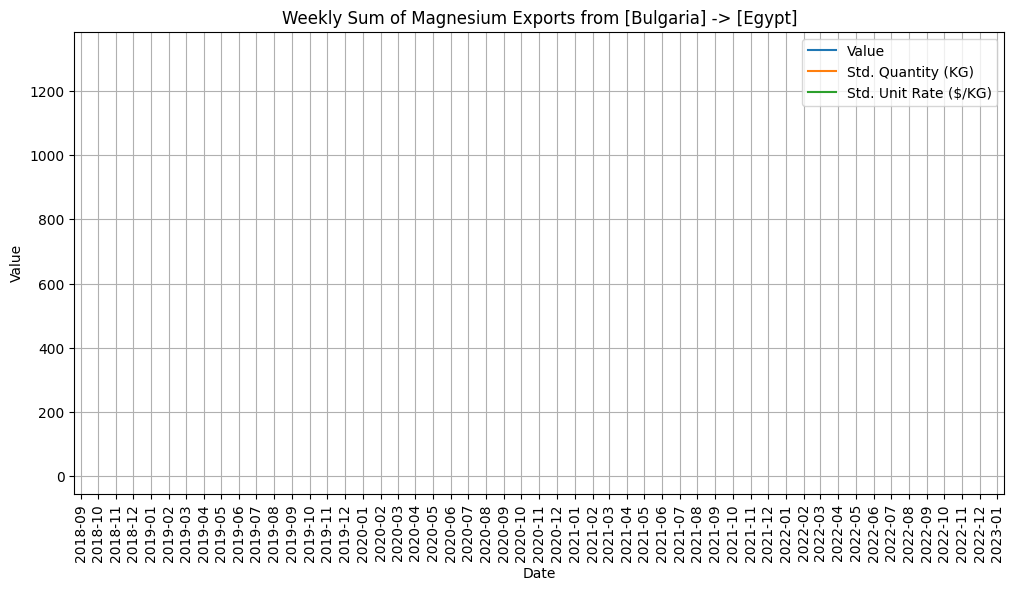

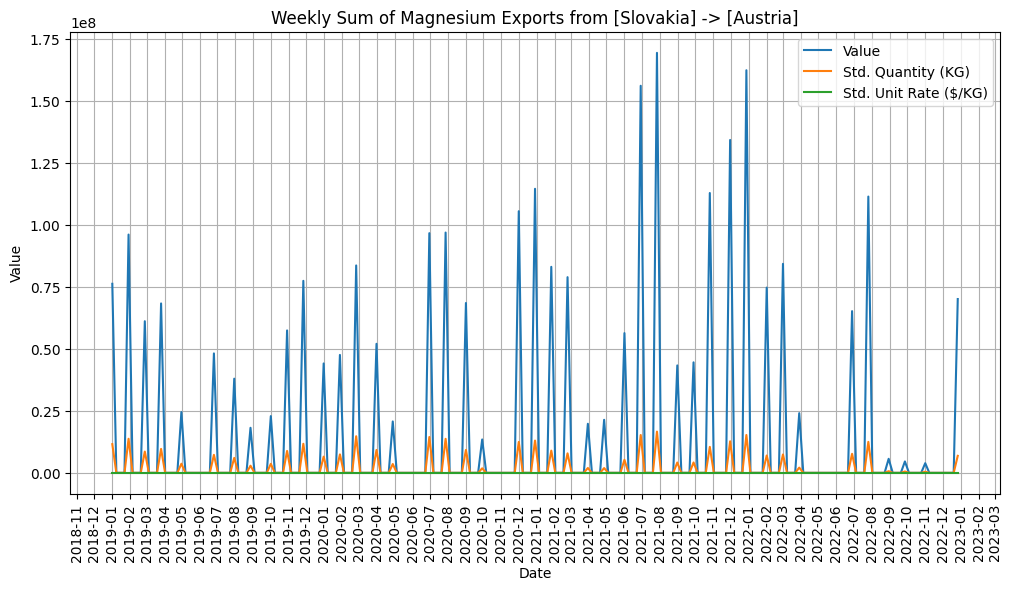

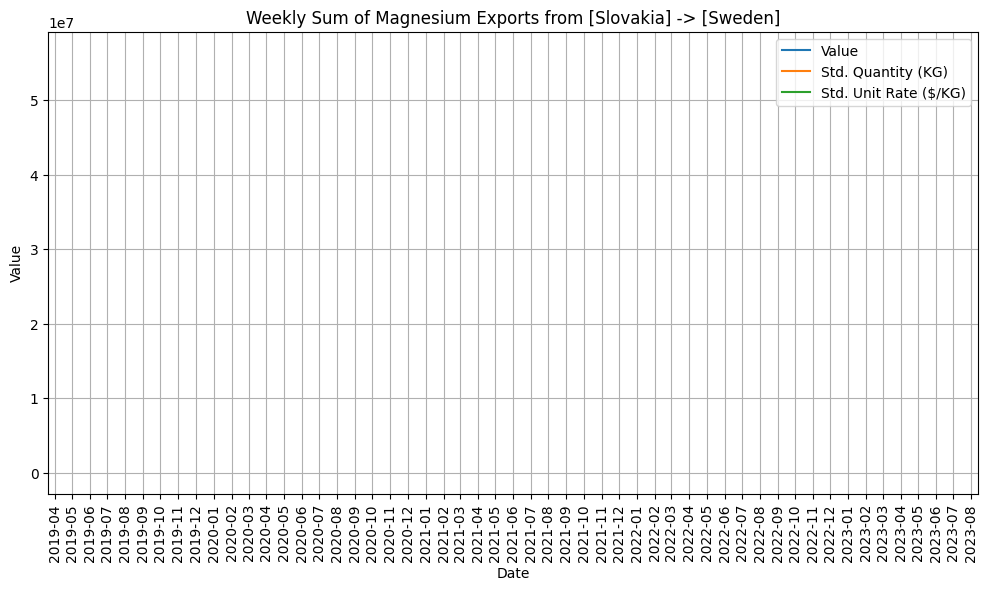

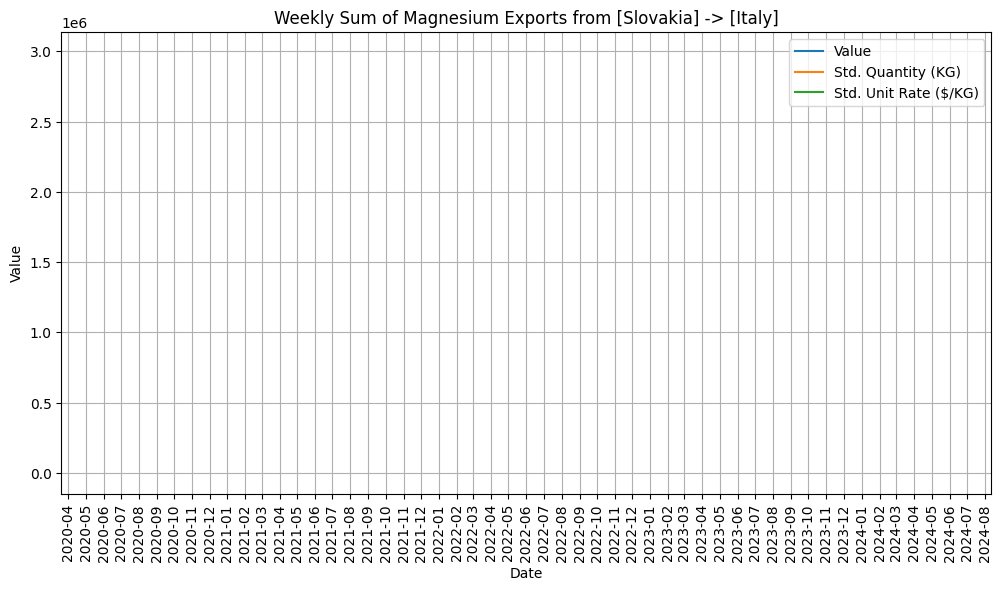

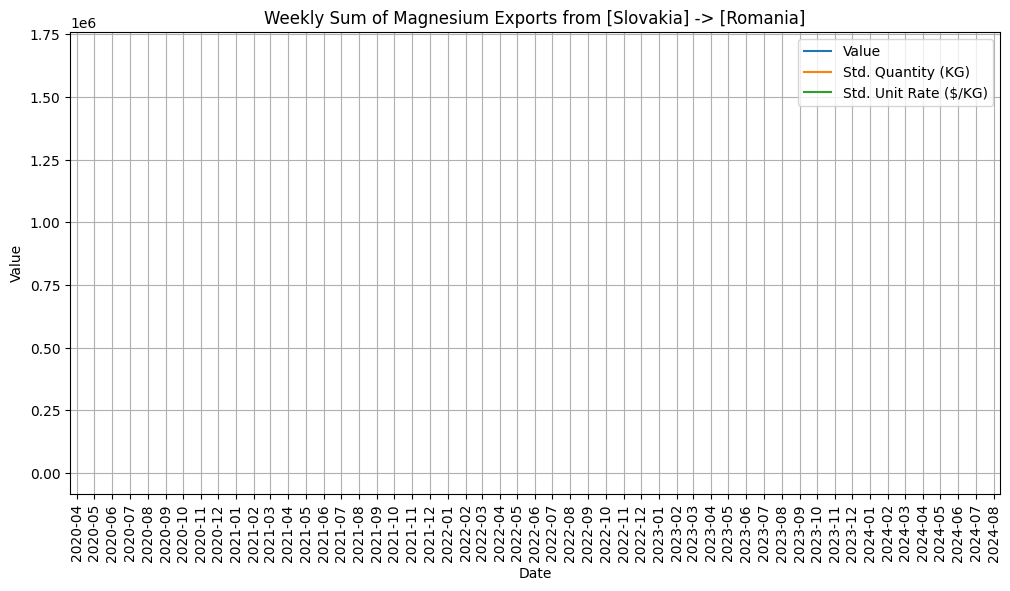

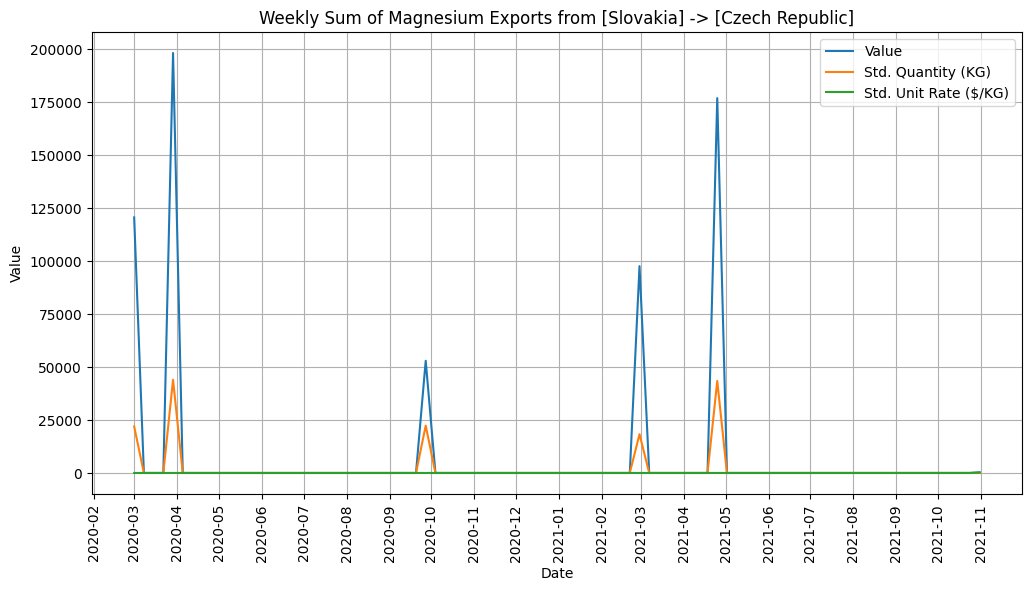

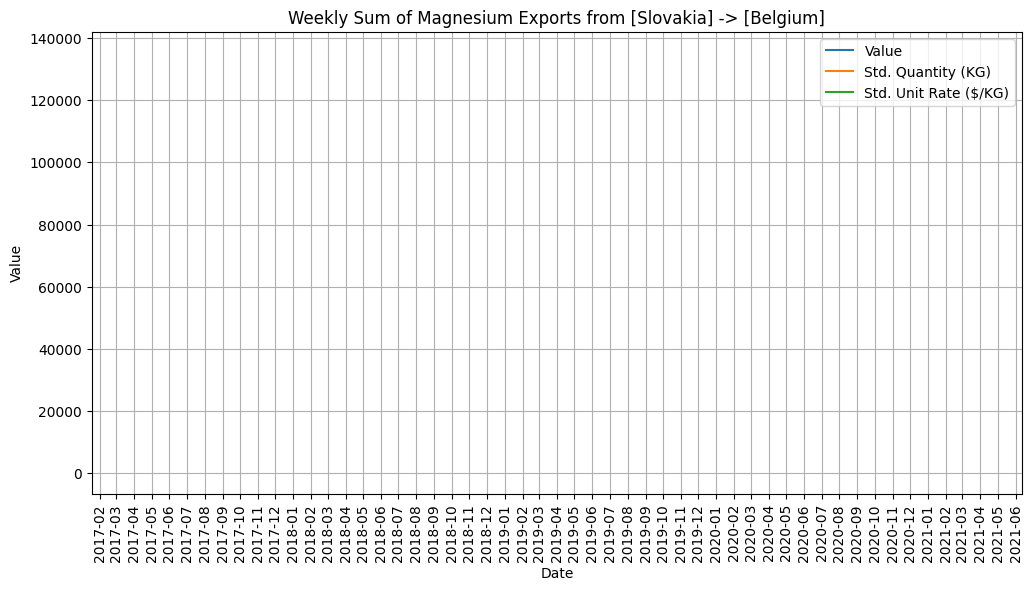

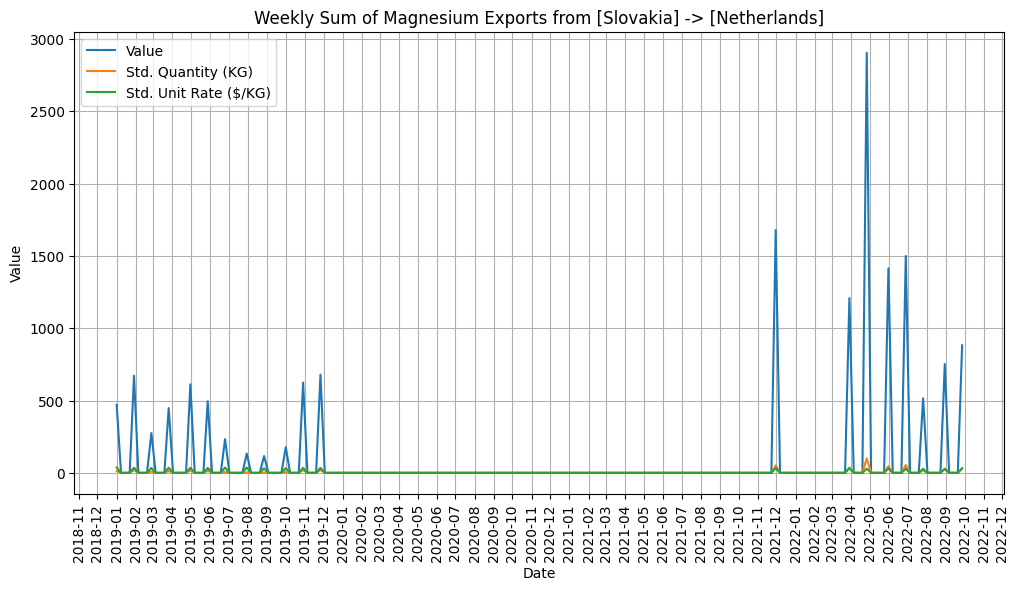

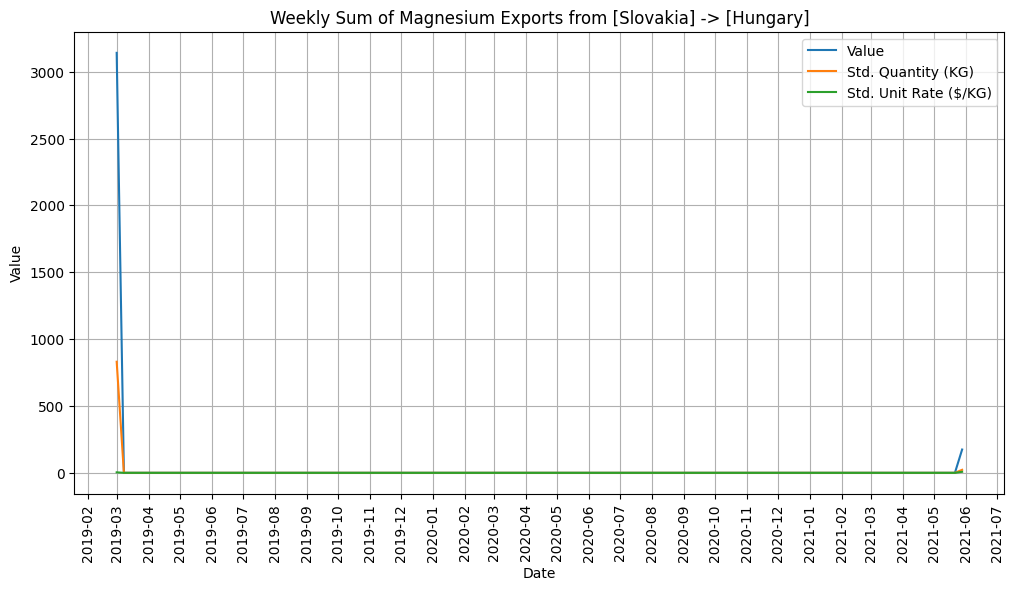

In [13]:
# Plotting
NUMERIC_COLUMN = ['Value', 'Std. Quantity (KG)', 'Std. Unit Rate ($/KG)']
TIME_METRIC = '7D'

for exporter, importers in top_importers_by_exporter.items():
    for importer in importers:
        export_import_data = combined_df[(combined_df['Country of Origin'] == exporter) & (combined_df['Country of Destination'] == importer)]

        # Resample and sum
        weekly_data = export_import_data[NUMERIC_COLUMN].resample(TIME_METRIC).sum()

        # Plotting
        plt.figure(figsize=(12, 6))
        for column in NUMERIC_COLUMN:
            plt.plot(weekly_data.index, weekly_data[column], label=column)

        plt.title(f'Weekly Sum of Magnesium Exports from [{exporter}] -> [{importer}]')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=90)
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.show()


#### **2. Correlation**
##### **2.1 Correlation between Commodity Value & Crude Oil Value**
##### **2.1.1 Spearman + Pearson Correlation, Linear Regression**

In [14]:
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr

# Resample and sum the data globally
monthly_commodity_data = combined_df[VALUE_COLUMN].resample(TIME_METRIC).sum()
monthly_oil_data = filtered_df[['WTI Oil Value', 'Brent Oil Value']].resample(TIME_METRIC).mean()

# Merge the two dataframes on the date index
combined_monthly = pd.DataFrame({'Commodity_Value': monthly_commodity_data, 'WTI_Oil_Value': monthly_oil_data['WTI Oil Value'], 'Brent_Oil_Value': monthly_oil_data['Brent Oil Value']})
combined_monthly.dropna(inplace=True)

# Correlation Analysis between Commodity Value and Oil Prices
for oil_type in ['WTI_Oil_Value', 'Brent_Oil_Value']:
    print(f"Correlation with {oil_type}:")
    pearson_corr, _ = pearsonr(combined_monthly['Commodity_Value'], combined_monthly[oil_type])
    spearman_corr, _ = spearmanr(combined_monthly['Commodity_Value'], combined_monthly[oil_type])
    print(f"Pearson Correlation Coefficient: {pearson_corr}")
    print(f"Spearman Correlation Coefficient: {spearman_corr}\n")

    # Regression Analysis
    X = sm.add_constant(combined_monthly[oil_type])  # Add a constant term to the predictor
    y = combined_monthly['Commodity_Value']
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)

    # Plotting the linear regression
    plt.scatter(combined_monthly[oil_type], y, label='Data Points')
    plt.plot(combined_monthly[oil_type], predictions, color='red', label='Regression Line')
    plt.xlabel(f'{oil_type} (USD per Barrel)')
    plt.ylabel(f'{COMMODITY} Value')
    plt.title(f'Linear Regression Analysis with {oil_type}')
    plt.legend()
    plt.show()


Correlation with WTI_Oil_Value:


ValueError: x and y must have length at least 2.

##### **2.1.2 Cross Correlation**

In [ ]:
# Cross-Correlation Function
def cross_correlation(ts1, ts2, lag=10):
    correlation = [ts1.corr(ts2.shift(i)) for i in range(-lag, lag + 1)]
    return correlation

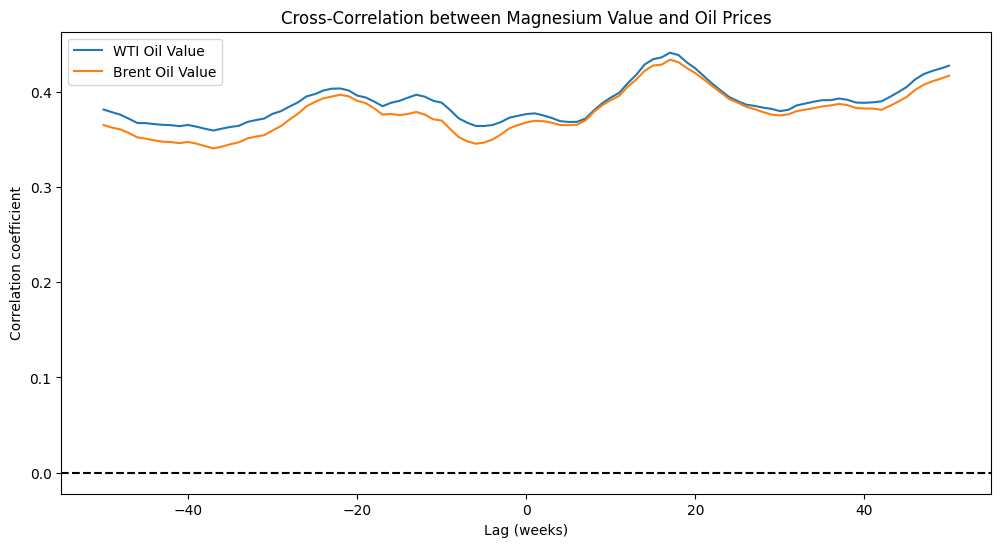

In [ ]:
# Aligning the time series on the same date range

start_date = '2020-01-01'
end_date = '2023-01-01'
filtered_df = filtered_df[(filtered_df.index >= pd.to_datetime(start_date)) & (filtered_df.index <= pd.to_datetime(end_date))]
weekly_global_data = weekly_global_data[(weekly_global_data.index >= pd.to_datetime(start_date)) & (weekly_global_data.index <= pd.to_datetime(end_date))]

# Compute cross-correlation
lag = 50
cross_corr_wti = cross_correlation(weekly_global_data[VALUE_COLUMN], filtered_df['WTI Oil Value'], lag)
cross_corr_brent = cross_correlation(weekly_global_data[VALUE_COLUMN], filtered_df['Brent Oil Value'], lag)

# Plot cross-correlation
plt.figure(figsize=(12, 6))
plt.plot(range(-lag, lag + 1), cross_corr_wti, label='WTI Oil Value')
plt.plot(range(-lag, lag + 1), cross_corr_brent, label='Brent Oil Value')
plt.title(f'Cross-Correlation between {COMMODITY} Value and Oil Prices')
plt.xlabel('Lag (weeks)')
plt.ylabel('Correlation coefficient')
plt.axhline(y=0, linestyle='--', color='k')
plt.legend()
plt.show()

##### **2.2 Correlation between Commodity Value & Quantity Shipped**

Exporter: China
Pearson Correlation Coefficient: 0.24580899151127286
Spearman Correlation Coefficient: 0.8489934576884212



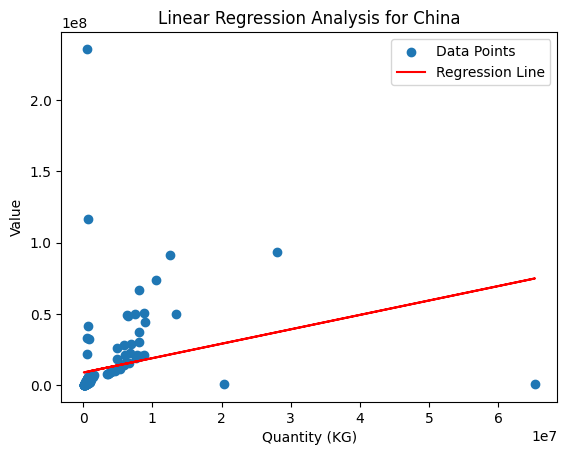

Exporter: Netherlands
Pearson Correlation Coefficient: 0.9404518525251309
Spearman Correlation Coefficient: 0.9984962820548811



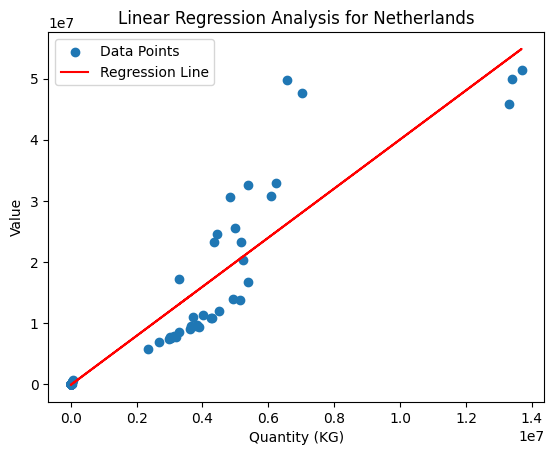

Exporter: Turkey
Pearson Correlation Coefficient: 0.869676844567301
Spearman Correlation Coefficient: 0.8865420808092691



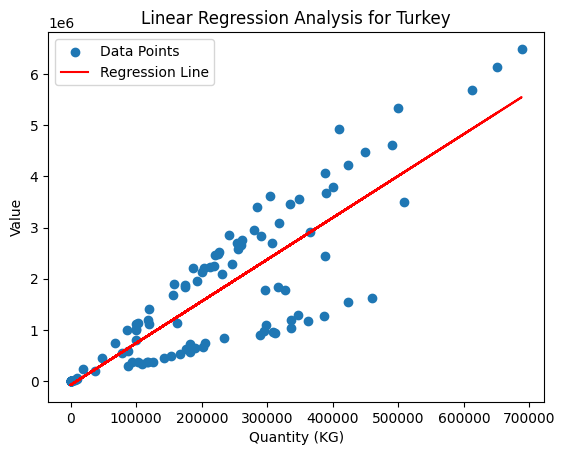

Exporter: Germany
Pearson Correlation Coefficient: 0.9048247281890912
Spearman Correlation Coefficient: 0.9908012780691121



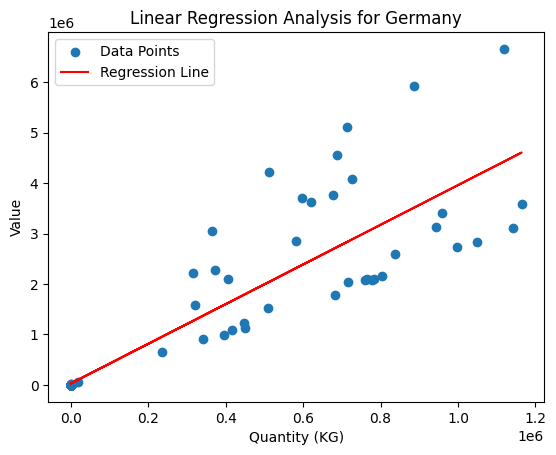

Exporter: Belgium
Pearson Correlation Coefficient: 0.8678083268241872
Spearman Correlation Coefficient: 0.9969089785083094



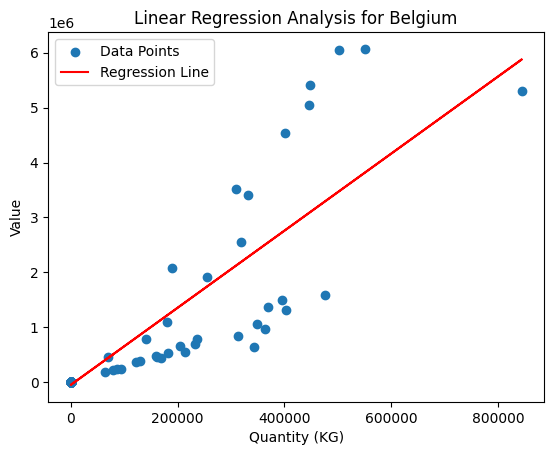

In [ ]:
# Analyze each top exporter
for exporter in top_exporters:
    # Filter and resample data for the exporter
    exporter_data = combined_df[combined_df[ORIGIN_COUNTRY_COLUMN] == exporter]
    monthly_exporter_data = exporter_data[[VALUE_COLUMN, QUANTITY_COLUMN]].resample(TIME_METRIC).sum()
    monthly_exporter_data.dropna(inplace=True)

    # Correlation Analysis
    pearson_corr, _ = pearsonr(monthly_exporter_data[VALUE_COLUMN], monthly_exporter_data[QUANTITY_COLUMN])
    spearman_corr, _ = spearmanr(monthly_exporter_data[VALUE_COLUMN], monthly_exporter_data[QUANTITY_COLUMN])
    print(f"Exporter: {exporter}")
    print(f"Pearson Correlation Coefficient: {pearson_corr}")
    print(f"Spearman Correlation Coefficient: {spearman_corr}\n")

    # Regression Analysis
    X = sm.add_constant(monthly_exporter_data[QUANTITY_COLUMN])  # Add a constant term to the predictor
    y = monthly_exporter_data[VALUE_COLUMN]
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)

    # Plotting the linear regression
    plt.scatter(monthly_exporter_data[QUANTITY_COLUMN], y, label='Data Points')
    plt.plot(monthly_exporter_data[QUANTITY_COLUMN], predictions, color='red', label='Regression Line')
    plt.xlabel('Quantity (KG)')
    plt.ylabel('Value')
    plt.title(f'Linear Regression Analysis for {exporter}')
    plt.legend()
    plt.show()


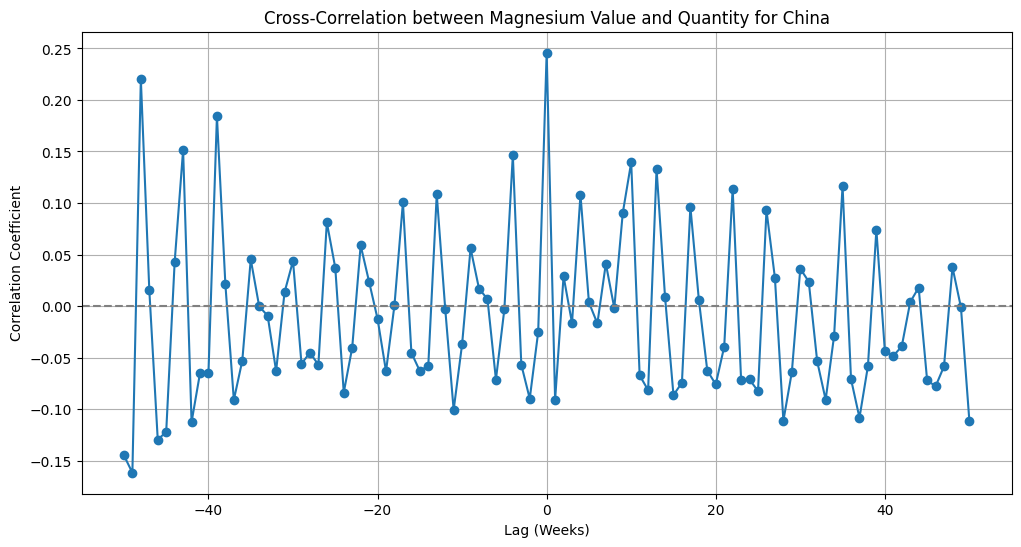

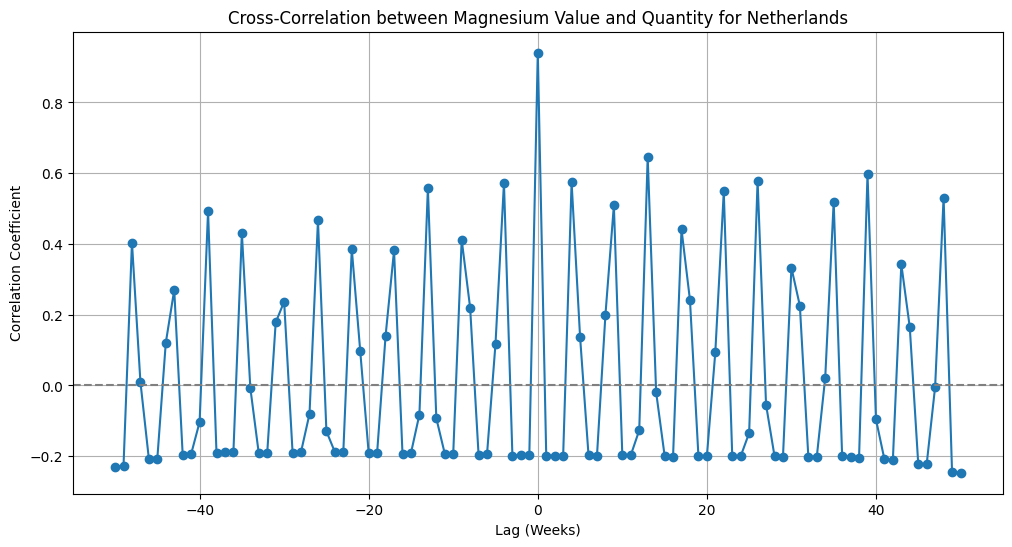

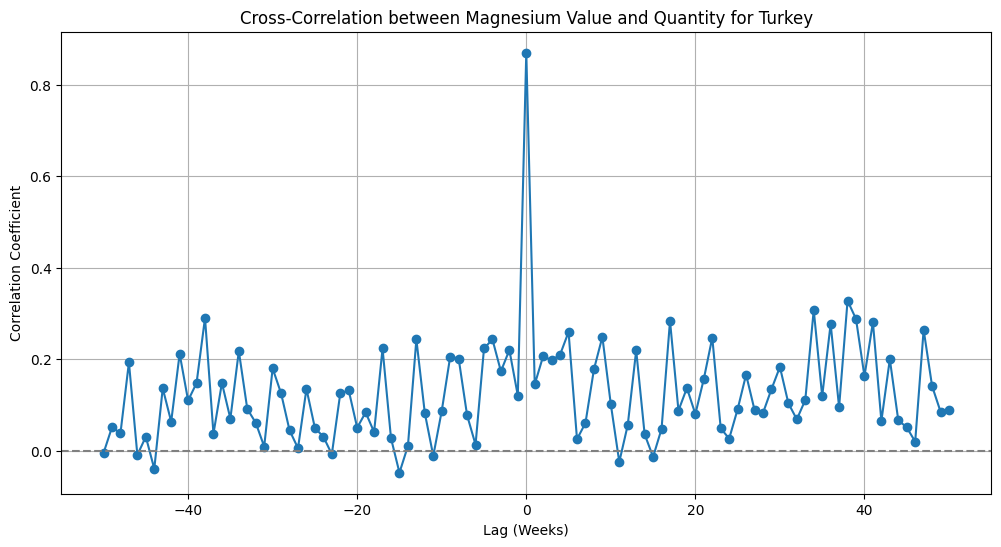

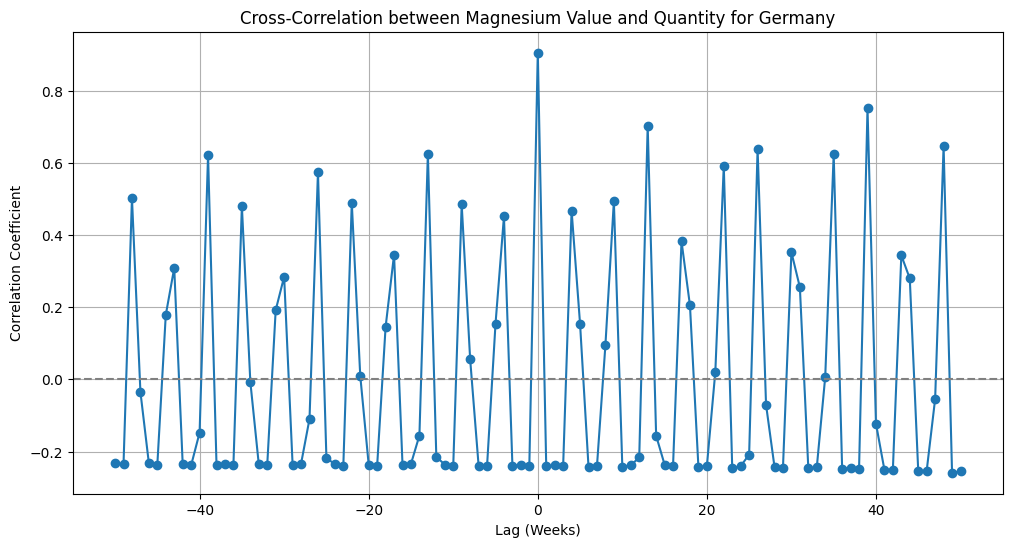

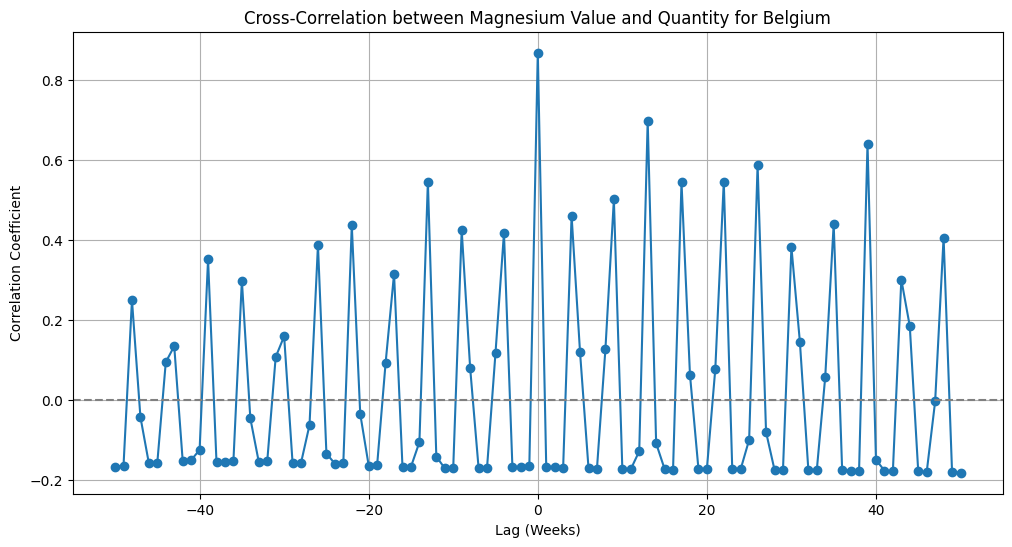

In [ ]:
# Analyze each top exporter
for exporter in top_exporters:
    # Filter and resample data for the exporter
    exporter_data = combined_df[combined_df[ORIGIN_COUNTRY_COLUMN] == exporter]
    monthly_exporter_data = exporter_data[[VALUE_COLUMN, QUANTITY_COLUMN]].resample(TIME_METRIC).sum()
    monthly_exporter_data.dropna(inplace=True)

    # Compute cross-correlation
    lag = 50
    corr_values = cross_correlation(monthly_exporter_data[VALUE_COLUMN], monthly_exporter_data[QUANTITY_COLUMN], lag)

    # Plot cross-correlation
    plt.figure(figsize=(12, 6))
    plt.plot(range(-lag, lag + 1), corr_values, marker='o')
    plt.axhline(y=0, linestyle='--', color='grey')
    plt.title(f'Cross-Correlation between {COMMODITY} Value and Quantity for {exporter}')
    plt.xlabel('Lag (Weeks)')
    plt.ylabel('Correlation Coefficient')
    plt.grid(True)
    plt.show()